<a href="https://colab.research.google.com/github/sidddha2004/UAV_2/blob/main/uav_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import warnings

def create_beam_codebook(n_azimuth=8, n_elevation=8): # <-- Changed to 8x8
    """
    Creates a 3D beam codebook.

    Returns:
        A list of tuples: (beam_index, 3d_unit_vector)
    """
    print(f"Creating a 3D beam codebook with {n_azimuth} azimuth and {n_elevation} elevation beams...")

    codebook_vectors = []
    beam_idx = 0

    # Create a grid of angles
    # Azimuth: -pi to +pi (horizontal)
    azimuths = np.linspace(-np.pi, np.pi, n_azimuth, endpoint=False)
    # Elevation: -pi/2 to +pi/2 (vertical)
    # Using n_elevation + 2 and slicing [1:-1] avoids the poles (straight up/down)
    # which are often problematic. This creates a more uniform grid.
    elevations = np.linspace(-np.pi/2, np.pi/2, n_elevation + 2)[1:-1]

    for az in azimuths:
        for el in elevations:
            # Convert spherical coordinates (az, el) to a 3D cartesian unit vector
            x = np.cos(el) * np.cos(az)
            y = np.cos(el) * np.sin(az)
            z = np.sin(el)

            vec = np.array([x, y, z])
            codebook_vectors.append((beam_idx, vec))
            beam_idx += 1

    print(f"Total beams in codebook: {len(codebook_vectors)}")
    if len(codebook_vectors) != n_azimuth * n_elevation:
         print(f"Warning: Codebook size ({len(codebook_vectors)}) does not match target ({n_azimuth * n_elevation}).")

    return codebook_vectors

def find_optimal_beam(true_aoa_vec, codebook_vectors):
    """
    Finds the best beam index by finding the maximum dot product.

    Args:
        true_aoa_vec (np.array): 3D unit vector of the UAV's true Angle of Arrival.
        codebook_vectors (list): The list of (beam_index, 3d_unit_vector)

    Returns:
        int: The index of the optimal beam.
    """
    max_dot = -np.inf
    best_beam_idx = -1

    for (idx, beam_vec) in codebook_vectors:
        # The "formula": dot product
        # A dot product of 1.0 means perfect alignment.
        dot_product = np.dot(true_aoa_vec, beam_vec)

        if dot_product > max_dot:
            max_dot = dot_product
            best_beam_idx = idx

    return best_beam_idx

def generate_uav_dataset(num_uavs=5, num_timesteps=5000, time_granularity=0.1):
    """
    Generates a synthetic UAV dataset with optimal beam index calculation.
    """

    total_samples = num_uavs * num_timesteps
    print(f"\nGenerating dataset for {num_uavs} UAVs over {num_timesteps} timesteps...")
    print(f"Total samples to be generated: {total_samples}")

    # --- 1. Simulation Parameters ---
    bs_pos = np.array([0, 0, 25])      # Base Station at (0, 0, 25m)

    # System Parameters
    tx_power_dbm = 23.0
    noise_power_dbm = -114.0
    noise_power_linear = 10**(noise_power_dbm / 10)
    fc_mhz = 3500  # Carrier Freq in MHz (3.5 GHz)
    c = 3e8  # Speed of light
    fc_hz = fc_mhz * 1e6
    sinr_threshold_db = 5.0
    num_rbs = 5 # Number of available Resource Blocks

    # Mobility Parameters
    vel_update_factor = 0.9  # For Gauss-Markov mobility
    vel_noise_std = 0.5      # Std dev of velocity noise
    uav_start_alt_range = [50, 150]

    # Channel Parameters
    path_loss_const = 32.4 + 20 * np.log10(fc_mhz) # FSPL constant
    shadowing_std = 4.0  # Log-normal shadowing std dev in dB

    # --- 2. Initialize Beamforming Codebook ---
    # N_AZIMUTH * N_ELEVATION = Total Beams
    beam_codebook = create_beam_codebook(n_azimuth=8, n_elevation=8) # 8x8 = 64 beams

    # --- 3. Initialize Data Structures ---
    data = {
        'UAV_ID': np.zeros(total_samples, dtype=int),
        'Timestamp': np.zeros(total_samples),
        'Pos_x': np.zeros(total_samples),
        'Pos_y': np.zeros(total_samples),
        'Pos_z': np.zeros(total_samples),
        'Vel_x': np.zeros(total_samples),
        'Vel_y': np.zeros(total_samples),
        'Vel_z': np.zeros(total_samples),
        'RSSI_dBm': np.zeros(total_samples),
        'SINR_dB': np.zeros(total_samples),
        'Interference_Power_dBm': np.zeros(total_samples),
        'Channel_Gain_dB': np.zeros(total_samples),
        'Doppler_Shift_Hz': np.zeros(total_samples),
        'AoA_Azimuth_rad': np.zeros(total_samples),
        'AoA_Elevation_rad': np.zeros(total_samples),
        'RB_Allocation': np.zeros(total_samples, dtype=int),
        'Tx_Power_dBm': np.full(total_samples, tx_power_dbm),
        'Interference_Event_Flag': np.zeros(total_samples, dtype=int),
        'Predicted_SINR_dB': np.zeros(total_samples),
        'Optimal_Beam_Index': np.zeros(total_samples, dtype=int), # Label 0-63
    }

    # Initialize UAV states
    uav_positions = np.random.rand(num_uavs, 3) * np.array([1000, 1000, 0]) - np.array([500, 500, 0])
    uav_positions[:, 2] = np.random.uniform(uav_start_alt_range[0], uav_start_alt_range[1], num_uavs)
    uav_velocities = np.random.normal(0, 5, (num_uavs, 3))

    # --- 4. Run Simulation Timestep by Timestep ---

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning) # Ignore log10(0) warnings

        for t_idx in range(num_timesteps):
            if (t_idx + 1) % 500 == 0:
                print(f"  ... processing timestep {t_idx+1} / {num_timesteps}")

            timestamp = t_idx * time_granularity

            current_rssi_linear = np.zeros(num_uavs)
            current_rb_alloc = np.random.randint(1, num_rbs + 1, num_uavs)

            # --- 4a. Update mobility and basic channel params for all UAVs ---
            for u_idx in range(num_uavs):
                # Update velocity (Gauss-Markov)
                uav_velocities[u_idx] = (vel_update_factor * uav_velocities[u_idx] +
                                        (1 - vel_update_factor) * np.random.normal(0, 5, 3) +
                                        np.random.normal(0, vel_noise_std, 3))

                # Update position
                uav_positions[u_idx] += uav_velocities[u_idx] * time_granularity

                pos = uav_positions[u_idx]
                vel = uav_velocities[u_idx]

                # Vector from UAV to BS
                vec_to_bs = bs_pos - pos
                distance = np.linalg.norm(vec_to_bs)
                distance_km = distance / 1000.0

                if distance_km == 0: distance_km = 0.001 # avoid log(0)

                # Path Loss (FSPL + Shadowing)
                path_loss_db = (path_loss_const + 20 * np.log10(distance_km) +
                                np.random.normal(0, shadowing_std))

                # Channel Gain & RSSI
                channel_gain_db = -path_loss_db
                rssi_dbm = tx_power_dbm + channel_gain_db
                current_rssi_linear[u_idx] = 10**(rssi_dbm / 10)

                # Doppler Shift
                radial_velocity = np.dot(vel, vec_to_bs) / distance
                doppler_shift = (radial_velocity * fc_hz) / c

                # Angle of Arrival (at BS)
                aoa_azimuth = np.arctan2(vec_to_bs[1], vec_to_bs[0])
                aoa_elevation = np.arcsin(vec_to_bs[2] / distance)

                # --- 4b. Calculate Optimal Beam Index (The "Formula") ---
                # Convert true AoA to a 3D unit vector
                true_aoa_vec = np.array([
                    np.cos(aoa_elevation) * np.cos(aoa_azimuth),
                    np.cos(aoa_elevation) * np.sin(aoa_azimuth),
                    np.sin(aoa_elevation)
                ])

                optimal_beam_idx = find_optimal_beam(true_aoa_vec, beam_codebook)

                # --- 4c. Store in main data array ---
                flat_idx = t_idx * num_uavs + u_idx
                data['UAV_ID'][flat_idx] = u_idx + 1
                data['Timestamp'][flat_idx] = timestamp
                data['Pos_x'][flat_idx], data['Pos_y'][flat_idx], data['Pos_z'][flat_idx] = pos
                data['Vel_x'][flat_idx], data['Vel_y'][flat_idx], data['Vel_z'][flat_idx] = vel
                data['RSSI_dBm'][flat_idx] = rssi_dbm
                data['Channel_Gain_dB'][flat_idx] = channel_gain_db
                data['Doppler_Shift_Hz'][flat_idx] = doppler_shift
                data['AoA_Azimuth_rad'][flat_idx] = aoa_azimuth
                data['AoA_Elevation_rad'][flat_idx] = aoa_elevation
                data['RB_Allocation'][flat_idx] = current_rb_alloc[u_idx]
                data['Optimal_Beam_Index'][flat_idx] = optimal_beam_idx # Store new label

            # --- 4d. Calculate Interference and SINR for all UAVs ---
            for u_idx in range(num_uavs):
                my_rb = current_rb_alloc[u_idx]

                # Find other UAVs on the same RB
                interferer_indices = np.where((current_rb_alloc == my_rb) & (np.arange(num_uavs) != u_idx))[0]

                if len(interferer_indices) > 0:
                    interference_linear = np.sum(current_rssi_linear[interferer_indices])
                else:
                    interference_linear = 0.0 # No co-channel interference

                interference_dbm = 10 * np.log10(interference_linear) if interference_linear > 0 else -np.inf

                # SINR = Signal / (Interference + Noise)
                signal_linear = current_rssi_linear[u_idx]
                sinr_linear = signal_linear / (interference_linear + noise_power_linear)
                sinr_db = 10 * np.log10(sinr_linear)

                # Store
                flat_idx = t_idx * num_uavs + u_idx
                data['Interference_Power_dBm'][flat_idx] = interference_dbm
                data['SINR_dB'][flat_idx] = sinr_db
                data['Interference_Event_Flag'][flat_idx] = 1 if sinr_db < sinr_threshold_db else 0

    # --- 5. Generate Shifted Labels ---
    print("  ... final processing (generating T+1 labels)")
    df = pd.DataFrame(data)

    # Create the 'Predicted_SINR_dB' (T+1) label
    df['Predicted_SINR_dB'] = df.groupby('UAV_ID')['SINR_dB'].shift(-1)

    # Fill the last timestep for each UAV
    df['Predicted_SINR_dB'] = df['Predicted_SINR_dB'].fillna(method='ffill')

    # --- 6. Clean up and Save ---
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(-999, inplace=True) # Fill NaNs with a placeholder

    output_filename = 'uav_synthetic_dataset_25k_64beams.csv' # <-- New filename
    df.to_csv(output_filename, index=False)

    print(f"\nSuccessfully generated {len(df)} samples.")
    print(f"Dataset saved to '{output_filename}'")
    print("\n--- Dataset Head ---")
    print(df.head())
    print(f"\nBeam Index range: {df['Optimal_Beam_Index'].min()} to {df['Optimal_Beam_Index'].max()}")
    print("\n--- Dataset Info ---")
    df.info()

# --- Run the generator ---
if __name__ == "__main__":
    # Ensure you have pandas and numpy installed:
    # pip install pandas numpy
    generate_uav_dataset(num_uavs=5, num_timesteps=5000)


Generating dataset for 5 UAVs over 5000 timesteps...
Total samples to be generated: 25000
Creating a 3D beam codebook with 8 azimuth and 8 elevation beams...
Total beams in codebook: 64
  ... processing timestep 500 / 5000
  ... processing timestep 1000 / 5000
  ... processing timestep 1500 / 5000
  ... processing timestep 2000 / 5000
  ... processing timestep 2500 / 5000
  ... processing timestep 3000 / 5000
  ... processing timestep 3500 / 5000
  ... processing timestep 4000 / 5000
  ... processing timestep 4500 / 5000
  ... processing timestep 5000 / 5000
  ... final processing (generating T+1 labels)


/tmp/ipython-input-1077456254.py:239: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Predicted_SINR_dB'] = df['Predicted_SINR_dB'].fillna(method='ffill')



Successfully generated 25000 samples.
Dataset saved to 'uav_synthetic_dataset_25k_64beams.csv'

--- Dataset Head ---
   UAV_ID  Timestamp       Pos_x       Pos_y       Pos_z     Vel_x      Vel_y  \
0       1        0.0  -19.591521 -176.992030   56.262686 -0.774422 -10.168744   
1       2        0.0 -437.648884   12.546917  129.916718 -3.999367   1.810852   
2       3        0.0 -144.674056  296.779451  120.985491  1.690898   5.696187   
3       4        0.0  -13.989348  312.209328  124.494312 -1.767422   3.638624   
4       5        0.0 -420.668162  -52.288516  138.775379  1.845237  -3.435020   

      Vel_z   RSSI_dBm    SINR_dB  Interference_Power_dBm  Channel_Gain_dB  \
0  5.016724 -65.469125  11.328686              -76.798639       -88.469125   
1 -1.913388 -76.798639 -11.329575              -65.469125       -99.798639   
2 -4.784781 -73.665724  40.334276             -999.000000       -96.665724   
3  0.360455 -59.049614  54.950386             -999.000000       -82.049614   
4  2.

Loading dataset 'uav_synthetic_dataset_25k_64beams.csv'...

--- 1. Interference Events per UAV ---
UAV_ID
1    1379
2    2701
3    2558
4    2455
5    2702
Name: Interference_Event_Flag, dtype: int64


/tmp/ipython-input-1678399061.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=uav_interference_count.index, y=uav_interference_count.values, palette="viridis")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


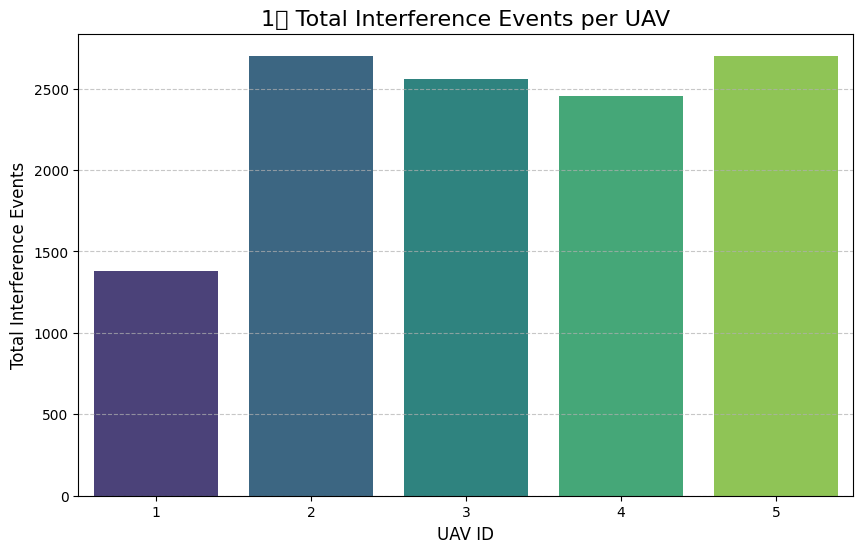


--- 2. Top 10 Most Problematic Beams ---
(Beam Index: Count of Interference Events)
Optimal_Beam_Index
35    5258
19    4121
51    1334
27     788
34     145
18     104
52      45
Name: count, dtype: int64


/tmp/ipython-input-1678399061.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_beams.values, y=top_10_beams.index, orient='h', palette="rocket")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


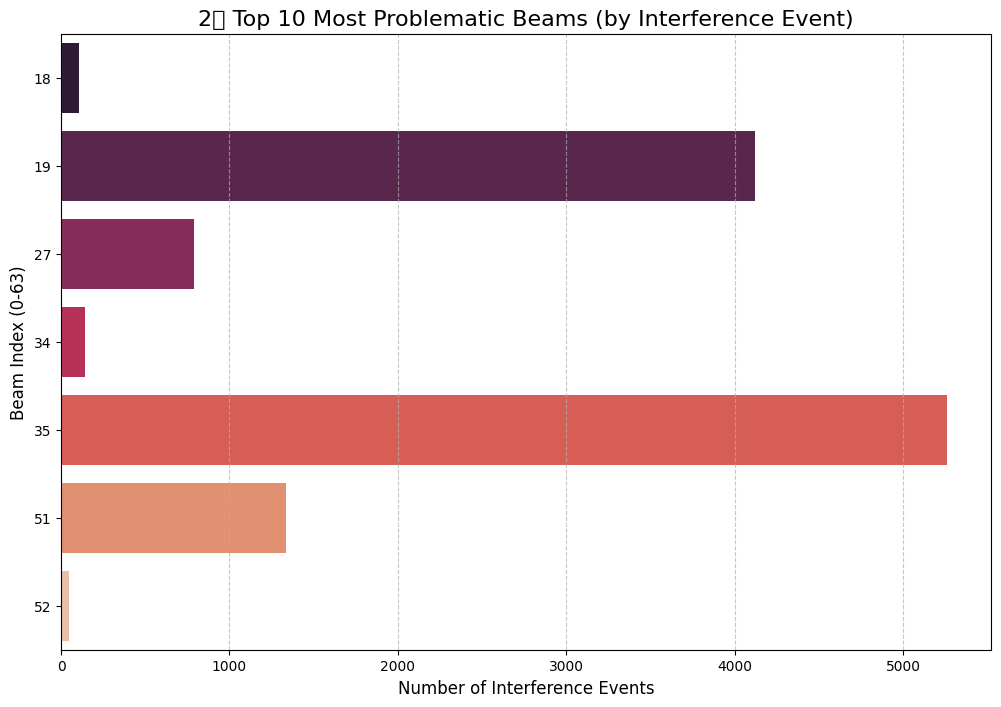


--- 3. Interference Over Time ---
Generating plot for total interference events vs. time...


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


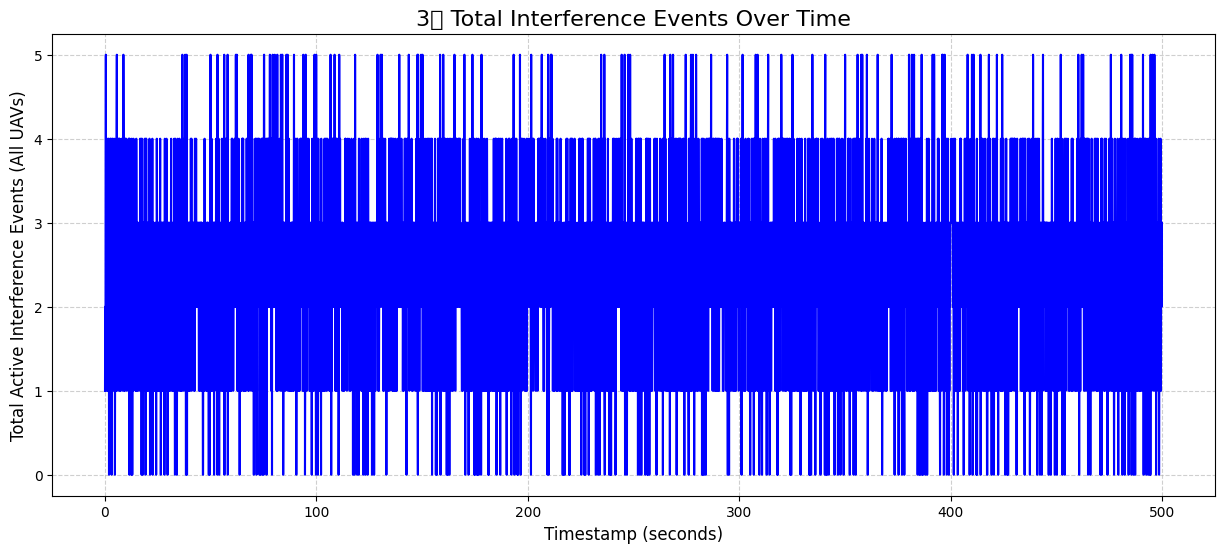

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_interference_patterns(csv_file, num_beams=64):
    """
    Loads the dataset and performs three analyses:
    1. Counts total interference events per UAV.
    2. Finds the most problematic beams (most involved in interference).
    3. Plots the total number of interference events over time.
    """

    print(f"Loading dataset '{csv_file}'...")
    try:
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"Error: File not found. Make sure '{csv_file}' is in the same directory.")
        return
    except Exception as e:
        print(f"An error occurred loading the file: {e}")
        return

    # --- 1️⃣ Count total interferences per UAV ---

    # The 'Interference_Event_Flag' is 1 for an interference event, 0 otherwise.
    # We can just sum this flag for each UAV.
    uav_interference_count = df.groupby('UAV_ID')['Interference_Event_Flag'].sum()

    print("\n--- 1. Interference Events per UAV ---")
    print(uav_interference_count)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=uav_interference_count.index, y=uav_interference_count.values, palette="viridis")
    plt.title('1️⃣ Total Interference Events per UAV', fontsize=16)
    plt.xlabel('UAV ID', fontsize=12)
    plt.ylabel('Total Interference Events', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # --- 2️⃣ Find most problematic beams ---

    # First, filter the DataFrame to get only the rows where interference occurred.
    interfered_rows = df[df['Interference_Event_Flag'] == 1]

    if interfered_rows.empty:
        print("\n--- 2. Most Problematic Beams ---")
        print("No interference events were found in the dataset.")
    else:
        # Now, count which beams appear most often in these interference events.
        problematic_beams = interfered_rows['Optimal_Beam_Index'].value_counts()

        # Get the top 10
        top_10_beams = problematic_beams.nlargest(10)

        print("\n--- 2. Top 10 Most Problematic Beams ---")
        print("(Beam Index: Count of Interference Events)")
        print(top_10_beams)

        plt.figure(figsize=(12, 8))
        # Horizontal bar plot is great for "Top N" lists
        sns.barplot(x=top_10_beams.values, y=top_10_beams.index, orient='h', palette="rocket")
        plt.title('2️⃣ Top 10 Most Problematic Beams (by Interference Event)', fontsize=16)
        plt.xlabel('Number of Interference Events', fontsize=12)
        plt.ylabel('Beam Index (0-63)', fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.show()


    # --- 3️⃣ Check interference over time ---

    # Group by Timestamp and sum all interference flags at that moment.
    interference_over_time = df.groupby('Timestamp')['Interference_Event_Flag'].sum()

    print("\n--- 3. Interference Over Time ---")
    print("Generating plot for total interference events vs. time...")

    plt.figure(figsize=(15, 6))
    sns.lineplot(x=interference_over_time.index, y=interference_over_time.values, color="blue")
    plt.title('3️⃣ Total Interference Events Over Time', fontsize=16)
    plt.xlabel('Timestamp (seconds)', fontsize=12)
    plt.ylabel('Total Active Interference Events (All UAVs)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# --- Run the analysis ---
if __name__ == "__main__":
    # Ensure you have pandas, matplotlib, and seaborn installed:
    # pip install pandas matplotlib seaborn

    # Make sure this file is in the same folder as your script
    analyze_interference_patterns('uav_synthetic_dataset_25k_64beams.csv')

Loading dataset 'uav_synthetic_dataset_25k_64beams.csv'...
Initializing 64x64 interference matrix...
Processing 16870 (Timestamp, RB) groups to find interference pairs...


100%|██████████| 16870/16870 [00:00<00:00, 25370.87it/s]


Interference processing complete.
Total unique interference pairs found: 9842
Generating probability heatmap...


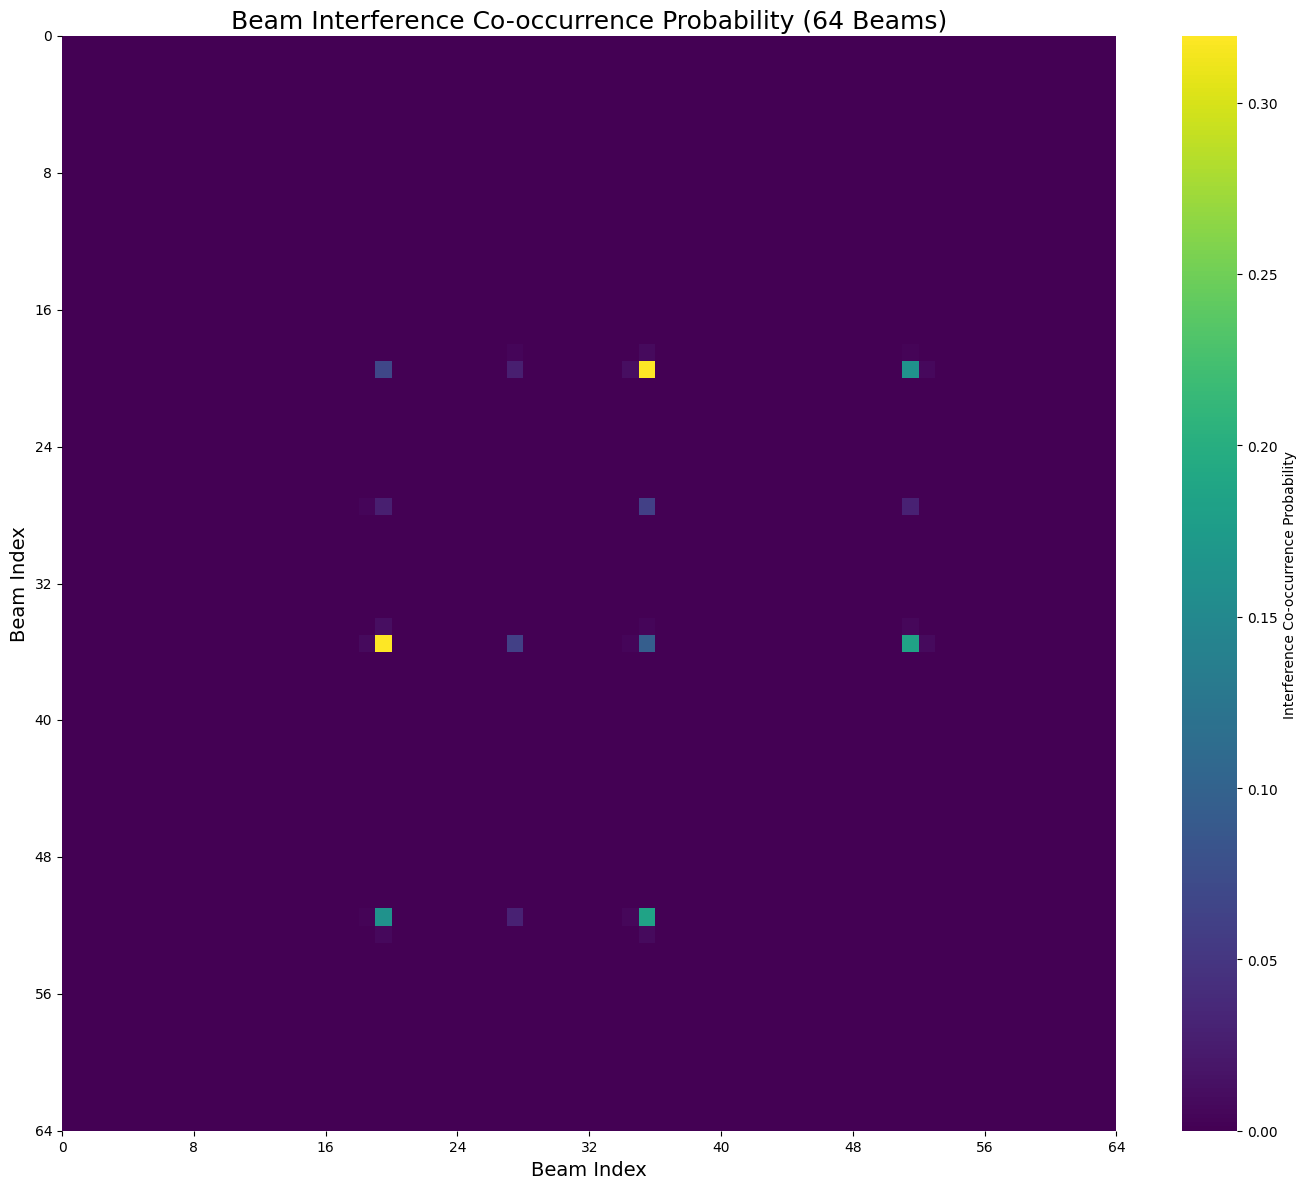


--- Interference Analysis ---
Total co-channel pairs found: 9842
  - On same beam (Diagonal):   1602 (16.3%)
  - On different beams (Off-diagonal): 8240 (83.7%)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm import tqdm
from matplotlib.colors import LogNorm

def visualize_beam_interference_probability(csv_file, num_beams=64):
    """
    Analyzes the dataset to find and visualize beam interference co-occurrence
    as a probability matrix.
    """

    print(f"Loading dataset '{csv_file}'...")
    try:
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"Error: File not found. Make sure '{csv_file}' is in the same directory.")
        return

    print(f"Initializing {num_beams}x{num_beams} interference matrix...")
    interference_matrix = np.zeros((num_beams, num_beams), dtype=int)

    # Group by Timestamp and RB.
    grouped = df.groupby(['Timestamp', 'RB_Allocation'])

    print(f"Processing {len(grouped)} (Timestamp, RB) groups to find interference pairs...")

    for (timestamp, rb), group in tqdm(grouped):
        if len(group) < 2:
            continue

        beams_in_group = group['Optimal_Beam_Index'].astype(int).tolist()

        for b1, b2 in combinations(beams_in_group, 2):
            interference_matrix[b1, b2] += 1
            if b1 != b2:
                interference_matrix[b2, b1] += 1

    print("Interference processing complete.")

    # --- SMALL CHANGE HERE: Convert counts to probability ---

    # Calculate total unique interference pairs
    # (We sum the upper triangle including the diagonal)
    total_interference_pairs = np.sum(np.triu(interference_matrix))

    if total_interference_pairs == 0:
        print("No interference events found. Cannot generate probability heatmap.")
        return

    # Divide the entire count matrix by the total pairs
    # This normalizes the matrix
    probability_matrix = interference_matrix / total_interference_pairs

    print(f"Total unique interference pairs found: {int(total_interference_pairs)}")
    print("Generating probability heatmap...")

    # --- Visualization ---
    plt.figure(figsize=(14, 12))

    # We now use a linear scale (0 to max probability)
    # and a different colormap ('viridis') which is good for linear data
    ax = sns.heatmap(
        probability_matrix,
        cmap='viridis',
        cbar_kws={'label': 'Interference Co-occurrence Probability'}
    )

    ax.set_title('Beam Interference Co-occurrence Probability (64 Beams)', fontsize=18)
    ax.set_xlabel('Beam Index', fontsize=14)
    ax.set_ylabel('Beam Index', fontsize=14)

    # Make ticks easier to read
    ax.set_xticks(np.arange(0, 65, 8))
    ax.set_yticks(np.arange(0, 65, 8))
    ax.set_xticklabels(np.arange(0, 65, 8))
    ax.set_yticklabels(np.arange(0, 65, 8))

    plt.tight_layout()
    plt.show()

    # --- Analysis (Still useful) ---
    diagonal_interference = np.sum(np.diag(interference_matrix))
    off_diagonal_interference = total_interference_pairs - diagonal_interference

    print("\n--- Interference Analysis ---")
    print(f"Total co-channel pairs found: {int(total_interference_pairs)}")
    print(f"  - On same beam (Diagonal):   {int(diagonal_interference)} ({diagonal_interference/total_interference_pairs:.1%})")
    print(f"  - On different beams (Off-diagonal): {int(off_diagonal_interference)} ({off_diagonal_interference/total_interference_pairs:.1%})")


# --- Run the visualization ---
if __name__ == "__main__":
    # Ensure you have pandas, matplotlib, seaborn, and tqdm installed:
    # pip install pandas matplotlib seaborn tqdm

    # Make sure this file is in the same folder as your script
    visualize_beam_interference_probability('uav_synthetic_dataset_25k_64beams.csv')

Loading data from uav_synthetic_dataset_25k_64beams.csv...
Creating sequences for each UAV...
Total sequences created: 24950
Train shapes: X=(19960, 10, 13), y=(19960,)
Test shapes:  X=(4990, 10, 13), y=(4990,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,496 (134.75 KB)

 Trainable params: 34,496 (134.75 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training (Beam Prediction)...
Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6291 - loss: 1.8171 - val_accuracy: 0.9760 - val_loss: 0.2513
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9660 - loss: 0.2290 - val_accuracy: 0.9795 - val_loss: 0.0936
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9794 - loss: 0.1133 - val_accuracy: 0.9765 - val_loss: 0.0959
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9793 - loss: 0.0917 - val_accuracy: 0.9910 - val_loss: 0.0335
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9876 - loss: 0.0526 - val_accuracy: 0.9880 - val_loss: 0.0334
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9905 - loss: 0.0378 - val_accuracy: 0.9930 - val_loss: 0.0212
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9908 - loss: 0.0339 - val_accuracy: 0.9925 - val_loss: 0.0193
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accu

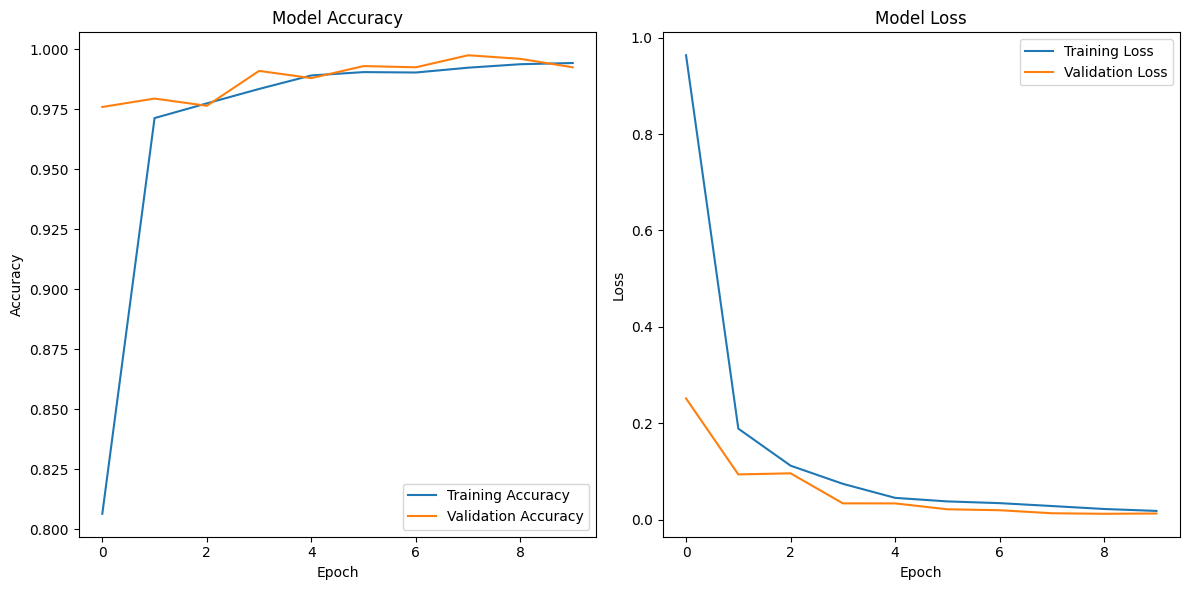


Making predictions on a few test samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predicted Beam Indices: [51 19 35 35 51]
Actual Beam Indices:  [51 19 35 35 51]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# --- 1. Parameters ---
CSV_FILE = 'uav_synthetic_dataset_25k_64beams.csv'
SEQUENCE_LENGTH = 10  # Use 10 past timesteps to predict the next one
NUM_BEAMS = 64

# --- 2. Define Features and Label ---
# Features (X)
FEATURES = [
    'Pos_x', 'Pos_y', 'Pos_z',
    'Vel_x', 'Vel_y', 'Vel_z',
    'RSSI_dBm', 'SINR_dB', 'Interference_Power_dBm',
    'Doppler_Shift_Hz', 'AoA_Azimuth_rad', 'AoA_Elevation_rad',
    'RB_Allocation'
]
# Label (y)
LABEL = 'Optimal_Beam_Index'

def create_sequences(features_data, labels_data, sequence_length):
    """
    Creates time-series sequences for a single UAV.
    """
    X_seq, y_seq = [], []
    for i in range(len(features_data) - sequence_length):
        # Input sequence
        X_seq.append(features_data[i:(i + sequence_length)])
        # Label at the end of the sequence
        y_seq.append(labels_data[i + sequence_length - 1])
    return np.array(X_seq), np.array(y_seq)

def plot_history(history):
    """Plots training history."""
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- 3. Load and Preprocess Data ---
print(f"Loading data from {CSV_FILE}...")
try:
    df = pd.read_csv(CSV_FILE)
except FileNotFoundError:
    print(f"Error: {CSV_FILE} not found.")
    exit()

# Handle -inf values from interference calc
df.replace([np.inf, -np.inf], -999, inplace=True)

# Scale features
scaler = MinMaxScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

all_X_seq, all_y_seq = [], []

print("Creating sequences for each UAV...")
for uav_id in df['UAV_ID'].unique():
    uav_df = df[df['UAV_ID'] == uav_id].copy()

    # Get scaled features and labels for this UAV
    uav_features = uav_df[FEATURES].values
    uav_labels = uav_df[LABEL].values

    # Create sequences for this one UAV
    X_uav, y_uav = create_sequences(uav_features, uav_labels, SEQUENCE_LENGTH)

    if len(X_uav) > 0:
        all_X_seq.append(X_uav)
        all_y_seq.append(y_uav)

# Combine sequences from all UAVs
X_total = np.concatenate(all_X_seq, axis=0)
y_total = np.concatenate(all_y_seq, axis=0)

# We don't one-hot encode y_total because we will use
# 'sparse_categorical_crossentropy'
print(f"Total sequences created: {X_total.shape[0]}")

# --- 4. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_total, test_size=0.2, random_state=42, stratify=y_total
)
print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes:  X={X_test.shape}, y={y_test.shape}")

# --- 5. Build LSTM Model (Classification) ---
model = Sequential()
model.add(LSTM(64, input_shape=(SEQUENCE_LENGTH, len(FEATURES)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(NUM_BEAMS, activation='softmax')) # Output layer with 64 neurons

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy', # Use this for integer labels
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

# --- 6. Train Model ---
print("\nStarting model training (Beam Prediction)...")
history = model.fit(
    X_train, y_train,
    epochs=10, # Increase epochs for better accuracy
    batch_size=64,
    validation_split=0.1
)

# --- 7. Evaluate Model ---
print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Plot history
plot_history(history)

# --- 8. Make Predictions ---
print("\nMaking predictions on a few test samples...")
predictions = model.predict(X_test[:5])
predicted_indices = np.argmax(predictions, axis=1)

print(f"Predicted Beam Indices: {predicted_indices}")
print(f"Actual Beam Indices:  {y_test[:5]}")

Loading data from uav_synthetic_dataset_25k_64beams.csv...
Creating sequences for each UAV...
Total sequences created: 24950
Train shapes: X=(19960, 10, 14), y=(19960,)
Test shapes:  X=(4990, 10, 14), y=(4990,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 64)         │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,673 (127.63 KB)

 Trainable params: 32,673 (127.63 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training (SINR Prediction)...
Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0823 - mae: 0.2482 - val_loss: 0.0611 - val_mae: 0.2308
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0643 - mae: 0.2327 - val_loss: 0.0621 - val_mae: 0.2275
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0632 - mae: 0.2328 - val_loss: 0.0633 - val_mae: 0.2422
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0626 - mae: 0.2327 - val_loss: 0.0610 - val_mae: 0.2357
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0624 - mae: 0.2327 - val_loss: 0.0613 - val_mae: 0.2371
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0621 - mae: 0.2328 - val_loss: 0.0609 - val_mae: 0.2342
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0618 - mae: 0.2320 - val_loss: 0.0619 - val_mae: 0.2267
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0620 - mae: 0.2333 - val_loss: 0.0608 - val_mae: 0.2341
Epoch 9/30

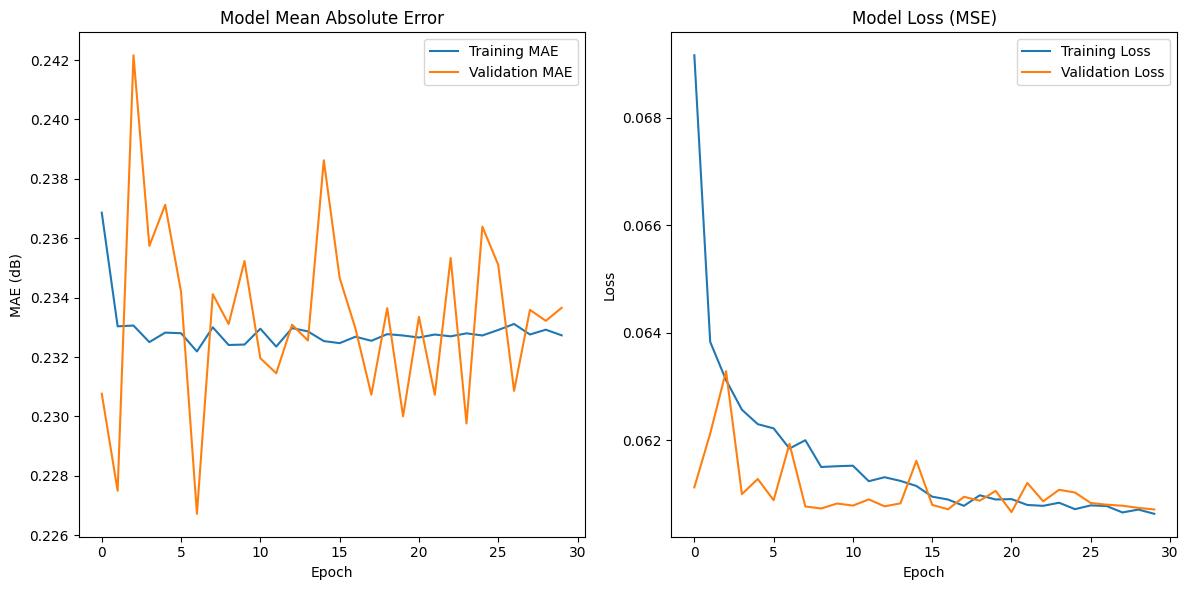


Making predictions on a few test samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Predicted vs Actual SINR (in dB):
  Predicted: 22.92 dB  |  Actual: 7.65 dB
  Predicted: 16.01 dB  |  Actual: 43.52 dB
  Predicted: 19.67 dB  |  Actual: 44.72 dB
  Predicted: 18.94 dB  |  Actual: 3.62 dB
  Predicted: 15.88 dB  |  Actual: 50.56 dB


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# --- 1. Parameters ---
CSV_FILE = 'uav_synthetic_dataset_25k_64beams.csv'
SEQUENCE_LENGTH = 10  # Use 10 past timesteps to predict the next one

# --- 2. Define Features and Label ---
# Features (X)
FEATURES = [
    'Pos_x', 'Pos_y', 'Pos_z',
    'Vel_x', 'Vel_y', 'Vel_z',
    'RSSI_dBm', 'SINR_dB', 'Interference_Power_dBm',
    'Doppler_Shift_Hz', 'AoA_Azimuth_rad', 'AoA_Elevation_rad',
    'RB_Allocation',
    'Optimal_Beam_Index' # We can use the beam index as a feature
]
# Label (y)
LABEL = 'Predicted_SINR_dB' # This is already T+1

def create_sequences(features_data, labels_data, sequence_length):
    """
    Creates time-series sequences for a single UAV.
    """
    X_seq, y_seq = [], []
    for i in range(len(features_data) - sequence_length):
        # Input sequence
        X_seq.append(features_data[i:(i + sequence_length)])
        # Label at the end of the sequence
        y_seq.append(labels_data[i + sequence_length - 1])
    return np.array(X_seq), np.array(y_seq)

def plot_history(history):
    """Plots training history."""
    plt.figure(figsize=(12, 6))

    # Plot training & validation MAE
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.ylabel('MAE (dB)')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training & validation loss (MSE)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- 3. Load and Preprocess Data ---
print(f"Loading data from {CSV_FILE}...")
try:
    df = pd.read_csv(CSV_FILE)
except FileNotFoundError:
    print(f"Error: {CSV_FILE} not found.")
    exit()

# Handle -inf values from interference calc
df.replace([np.inf, -np.inf], -999, inplace=True)
# The last label for each UAV is -999, let's drop them
df = df[df[LABEL] != -999]

# We must scale features AND the label for regression
scaler_features = MinMaxScaler()
scaler_label = MinMaxScaler()

df[FEATURES] = scaler_features.fit_transform(df[FEATURES])
df[LABEL] = scaler_label.fit_transform(df[[LABEL]])

all_X_seq, all_y_seq = [], []

print("Creating sequences for each UAV...")
for uav_id in df['UAV_ID'].unique():
    uav_df = df[df['UAV_ID'] == uav_id].copy()

    # Get scaled features and labels for this UAV
    uav_features = uav_df[FEATURES].values
    uav_labels = uav_df[LABEL].values

    # Create sequences for this one UAV
    X_uav, y_uav = create_sequences(uav_features, uav_labels, SEQUENCE_LENGTH)

    if len(X_uav) > 0:
        all_X_seq.append(X_uav)
        all_y_seq.append(y_uav)

# Combine sequences from all UAVs
X_total = np.concatenate(all_X_seq, axis=0)
y_total = np.concatenate(all_y_seq, axis=0)

print(f"Total sequences created: {X_total.shape[0]}")

# --- 4. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_total, test_size=0.2, random_state=42
)
print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes:  X={X_test.shape}, y={y_test.shape}")

# --- 5. Build LSTM Model (Regression) ---
model = Sequential()
model.add(LSTM(64, input_shape=(SEQUENCE_LENGTH, len(FEATURES)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear')) # Output layer with 1 neuron for regression

# Compile the model
model.compile(
    loss='mean_squared_error', # Use MSE for regression
    optimizer='adam',
    metrics=['mae'] # Mean Absolute Error
)
model.summary()

# --- 6. Train Model ---
print("\nStarting model training (SINR Prediction)...")
history = model.fit(
    X_train, y_train,
    epochs=30, # Increase epochs for better accuracy
    batch_size=64,
    validation_split=0.1
)

# --- 7. Evaluate Model ---
print("\nEvaluating model on test data...")
loss_mse, loss_mae = model.evaluate(X_test, y_test)

# Inverse transform the MAE to be interpretable in dB
# We approximate this by transforming the mean MAE
dummy_array_mae = np.zeros((1, 1))
dummy_array_mae[0, 0] = loss_mae
mae_in_db = scaler_label.inverse_transform(dummy_array_mae)[0, 0]
# Note: This scaling of error isn't perfect, but gives a good idea.

print(f"Test Mean Absolute Error (MAE): {loss_mae:.4f} (scaled)")
print(f"Test Loss (MSE): {loss_mse:.4f}")


# Plot history
plot_history(history)

# --- 8. Make Predictions ---
print("\nMaking predictions on a few test samples...")
predictions_scaled = model.predict(X_test[:5])
predictions_db = scaler_label.inverse_transform(predictions_scaled)

# Inverse transform the actual values for comparison
actual_scaled = y_test[:5].reshape(-1, 1)
actual_db = scaler_label.inverse_transform(actual_scaled)

print("Predicted vs Actual SINR (in dB):")
for pred, act in zip(predictions_db, actual_db):
    print(f"  Predicted: {pred[0]:.2f} dB  |  Actual: {act[0]:.2f} dB")

In [ ]:
# Probabilistic LoS/NLoS:

# There is a new function get_los_probability based on 3GPP standards. A UAV at a high elevation angle (e.g., directly overhead) has a high chance of being Line-of-Sight (LoS). A UAV at a low elevation angle (far away) has a high chance of being Non-Line-of-Sight (NLoS).

# A different, more severe path loss formula (path_loss_nlos_db) is applied to NLoS UAVs, creating realistic, sudden signal drops.

# Small-Scale Fading:

# A new function get_fading_gain_db is called every timestep.

# LoS signals get Rician fading (a strong main path + reflections).

# NLoS signals get Rayleigh fading (no main path, only reflections), which is much more severe and variable.

# Functional Beamforming (Most Important Change):

# The SINR calculation is completely rebuilt.

# Signal Power: The desired UAV's signal power now includes a +20 dB main lobe gain because the optimal beam is pointed at it.

# Interference Power: When an interfering UAV (on the same RB) is received, we calculate the angle between it and the desired UAV's beam.

# If the interferer is outside the main beam, its signal is hit with a -10 dB sidelobe gain (i.e., it is suppressed). This is the entire point of beamforming.

# This makes the simulation dynamic: interference now depends on the spatial separation of UAVs.

In [ ]:
import numpy as np
import pandas as pd
import warnings
from tqdm import trange

# --- 1. NEW CHANNEL & ANTENNA FUNCTIONS ---

def get_los_probability(elevation_angle_deg):
    """
    Calculates LoS probability based on a simplified 3GPP UMi model.
    High angle = high LoS prob. Low angle = low LoS prob.
    """
    if elevation_angle_deg < 0:
        return 0.0
    # Formula p1 * (1 - exp(-p2 * angle))
    p1 = 0.95
    p2 = 0.08
    prob = p1 * (1 - np.exp(-p2 * elevation_angle_deg))
    return min(prob, 1.0)

def get_fading_gain_db(is_los, k_factor_db=10):
    """
    Generates a single sample of Rician or Rayleigh fading gain in dB.
    """
    if is_los:
        # --- Rician Fading (LoS) ---
        # k_factor_db = 10 (Linear K=10)
        K = 10**(k_factor_db / 10)

        # Power of the dominant component
        s_power = K / (K + 1)
        # Power of the scattered components
        scatter_power = 1 / (K + 1)

        # Dominant component
        s = np.sqrt(s_power) * (np.random.normal(1, 0) + 1j * np.random.normal(0, 0))
        # Scattered components
        scatter = np.sqrt(scatter_power/2) * (np.random.normal(0, 1, 1) + 1j * np.random.normal(0, 1, 1))

        h = s + scatter
        power_gain_linear = np.abs(h)**2

    else:
        # --- Rayleigh Fading (NLoS) ---
        # Mean power is 1 (0 dB)
        h = np.sqrt(0.5) * (np.random.normal(0, 1, 1) + 1j * np.random.normal(0, 1, 1))
        power_gain_linear = np.abs(h)**2

    # Convert linear power gain to dB
    return 10 * np.log10(power_gain_linear[0])

def calculate_antenna_gain_db(target_vec, beam_vec, main_lobe_gain_db=20, sidelobe_gain_db=-10, beamwidth_deg=45):
    """
    Calculates the antenna gain applied to a target vector by a beam vector.
    Models a simple 'cone' beam pattern.
    """
    # Dot product: 1 = perfectly aligned, 0 = 90 deg off, -1 = opposite
    dot_product = np.dot(target_vec, beam_vec)

    # Ensure dot_product is in valid range for arccos
    dot_product = np.clip(dot_product, -1.0, 1.0)

    # Angle between the target and the beam's center
    angle_off_axis_rad = np.arccos(dot_product)
    angle_off_axis_deg = np.degrees(angle_off_axis_rad)

    # Check if target is inside the main beam cone
    if angle_off_axis_deg <= (beamwidth_deg / 2):
        return main_lobe_gain_db
    else:
        return sidelobe_gain_db

# --- 2. EXISTING BEAMFORMING FUNCTIONS (Unchanged) ---

def create_beam_codebook(n_azimuth=8, n_elevation=8):
    """Creates an 8x8=64 beam codebook."""
    codebook_vectors = []
    beam_idx = 0
    azimuths = np.linspace(-np.pi, np.pi, n_azimuth, endpoint=False)
    elevations = np.linspace(-np.pi/2, np.pi/2, n_elevation + 2)[1:-1]

    for az in azimuths:
        for el in elevations:
            x = np.cos(el) * np.cos(az)
            y = np.cos(el) * np.sin(az)
            z = np.sin(el)
            vec = np.array([x, y, z])
            codebook_vectors.append((beam_idx, vec))
            beam_idx += 1

    print(f"Created beam codebook with {len(codebook_vectors)} beams.")
    return codebook_vectors, {idx: vec for idx, vec in codebook_vectors} # Also return a dict for easy lookup

def find_optimal_beam(true_aoa_vec, codebook_vectors):
    """Finds the best beam index via max dot product."""
    max_dot = -np.inf
    best_beam_idx = -1
    best_beam_vec = None

    for (idx, beam_vec) in codebook_vectors:
        dot_product = np.dot(true_aoa_vec, beam_vec)
        if dot_product > max_dot:
            max_dot = dot_product
            best_beam_idx = idx
            best_beam_vec = beam_vec

    return best_beam_idx, best_beam_vec

# --- 3. MAIN DATA GENERATION SCRIPT ---

def generate_uav_dataset_realistic(num_uavs=5, num_timesteps=5000, time_granularity=0.1):

    total_samples = num_uavs * num_timesteps
    print(f"\nGenerating {total_samples} samples with REALISTIC channel models...")

    # --- Simulation Parameters ---
    bs_pos = np.array([0, 0, 25])
    tx_power_dbm = 23.0
    noise_power_dbm = -114.0
    noise_power_linear = 10**(noise_power_dbm / 10)
    fc_mhz = 3500
    c = 3e8
    fc_hz = fc_mhz * 1e6
    sinr_threshold_db = 5.0
    num_rbs = 5

    # Mobility
    vel_update_factor = 0.9
    vel_noise_std = 0.5
    uav_start_alt_range = [50, 150]

    # Channel
    pl_const_los = 32.4 + 20 * np.log10(fc_mhz) # FSPL for LoS
    pl_const_nlos = 35.3 + 37.6 * np.log10(fc_mhz) # 3GPP UMi NLoS constant
    rician_k_factor_db = 10

    # Antenna
    main_lobe_gain_db = 20.0  # High gain for main beam
    sidelobe_gain_db = -10.0 # Suppression for sidelobes
    beamwidth_deg = 45.0      # Cone width of one beam

    # --- Initialize Codebook ---
    beam_codebook, beam_dict = create_beam_codebook(n_azimuth=8, n_elevation=8)

    # --- Initialize Data Structures ---
    # We need to store intermediate values for the 2-pass SINR calculation
    columns = [
        'UAV_ID', 'Timestamp', 'Pos_x', 'Pos_y', 'Pos_z', 'Vel_x', 'Vel_y', 'Vel_z',
        'RSSI_dBm', 'SINR_dB', 'Interference_Power_dBm', 'Channel_Gain_dB',
        'Fading_Gain_dB', 'Doppler_Shift_Hz', 'AoA_Azimuth_rad', 'AoA_Elevation_rad',
        'RB_Allocation', 'Tx_Power_dBm', 'Interference_Event_Flag',
        'Optimal_Beam_Index', 'Is_LoS'
    ]
    df = pd.DataFrame(index=range(total_samples), columns=columns)

    # Intermediate stores for 2-pass calculation
    uav_states = {}
    for u_idx in range(num_uavs):
        uav_states[u_idx] = {
            'pos': (np.random.rand(3) * np.array([1000, 1000, 0]) - np.array([500, 500, 0]) +
                    np.array([0, 0, np.random.uniform(uav_start_alt_range[0], uav_start_alt_range[1])])),
            'vel': np.random.normal(0, 5, 3),
            'los_state': True
        }

    print("Starting simulation loop (this is now more complex)...")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)

        # Use trange for a progress bar
        for t_idx in trange(num_timesteps):
            timestamp = t_idx * time_granularity

            # --- Pass 1: Update states, calculate features & signal power ---

            # Store info needed for Pass 2 (Interference)
            pass_2_data = {}
            current_rb_alloc = np.random.randint(1, num_rbs + 1, num_uavs)

            for u_idx in range(num_uavs):
                flat_idx = t_idx * num_uavs + u_idx

                # Update mobility (Gauss-Markov)
                state = uav_states[u_idx]
                state['vel'] = (vel_update_factor * state['vel'] +
                                (1 - vel_update_factor) * np.random.normal(0, 5, 3) +
                                np.random.normal(0, vel_noise_std, 3))
                state['pos'] += state['vel'] * time_granularity

                pos, vel = state['pos'], state['vel']

                # --- Channel Calculations ---
                vec_to_bs = bs_pos - pos
                distance_m = np.linalg.norm(vec_to_bs)
                distance_km = distance_m / 1000.0

                # AoA
                aoa_azimuth_rad = np.arctan2(vec_to_bs[1], vec_to_bs[0])
                elevation_rad = np.arcsin(vec_to_bs[2] / distance_m)
                elevation_deg = np.degrees(elevation_rad)

                # 1. LoS/NLoS State
                los_prob = get_los_probability(elevation_deg)
                is_los = np.random.rand() < los_prob
                state['los_state'] = is_los

                # 2. Path Loss
                if is_los:
                    path_loss_db = pl_const_los + 20 * np.log10(distance_km)
                else:
                    path_loss_db = pl_const_nlos + 37.6 * np.log10(distance_km)

                # 3. Fading
                fading_gain_db = get_fading_gain_db(is_los, rician_k_factor_db)

                # Total Channel Gain (Path Loss + Fading)
                channel_gain_db = -path_loss_db + fading_gain_db

                # --- Beamforming ---
                true_aoa_vec = vec_to_bs / distance_m
                optimal_beam_idx, optimal_beam_vec = find_optimal_beam(true_aoa_vec, beam_codebook)

                # 4. Antenna Gain (Signal)
                # We assume the BS uses the optimal beam, so we get the full main lobe gain
                signal_antenna_gain_db = main_lobe_gain_db

                # --- RSSI (Received Signal Strength) ---
                # RSSI = TxPower + ChannelGain + AntennaGain
                rssi_dbm = tx_power_dbm + channel_gain_db + signal_antenna_gain_db

                # --- Doppler ---
                radial_velocity = np.dot(vel, vec_to_bs) / distance_m
                doppler_shift = (radial_velocity * fc_hz) / c

                # --- Store Features ---
                df.at[flat_idx, 'UAV_ID'] = u_idx + 1
                df.at[flat_idx, 'Timestamp'] = timestamp
                df.at[flat_idx, 'Pos_x'] = pos[0]
                df.at[flat_idx, 'Pos_y'] = pos[1]
                df.at[flat_idx, 'Pos_z'] = pos[2]
                df.at[flat_idx, 'Vel_x'] = vel[0]
                df.at[flat_idx, 'Vel_y'] = vel[1]
                df.at[flat_idx, 'Vel_z'] = vel[2]
                df.at[flat_idx, 'RSSI_dBm'] = rssi_dbm
                df.at[flat_idx, 'Channel_Gain_dB'] = channel_gain_db
                df.at[flat_idx, 'Fading_Gain_dB'] = fading_gain_db
                df.at[flat_idx, 'Doppler_Shift_Hz'] = doppler_shift
                df.at[flat_idx, 'AoA_Azimuth_rad'] = aoa_azimuth_rad
                df.at[flat_idx, 'AoA_Elevation_rad'] = elevation_rad
                df.at[flat_idx, 'RB_Allocation'] = current_rb_alloc[u_idx]
                df.at[flat_idx, 'Tx_Power_dBm'] = tx_power_dbm
                df.at[flat_idx, 'Optimal_Beam_Index'] = optimal_beam_idx
                df.at[flat_idx, 'Is_LoS'] = 1 if is_los else 0

                # Store data needed for Pass 2
                pass_2_data[u_idx] = {
                    'rssi_linear': 10**(rssi_dbm / 10),
                    'rb': current_rb_alloc[u_idx],
                    'optimal_beam_vec': optimal_beam_vec,
                    'true_aoa_vec': true_aoa_vec,
                    # We need "base" power (Tx + Channel) to calculate interference gain
                    'base_power_dbm': tx_power_dbm + channel_gain_db
                }

            # --- Pass 2: Calculate Interference and SINR ---

            for u_idx in range(num_uavs):
                flat_idx = t_idx * num_uavs + u_idx
                my_data = pass_2_data[u_idx]

                signal_linear = my_data['rssi_linear']
                my_beam_vec = my_data['optimal_beam_vec']

                interference_linear = 0.0

                # Find interferers (same RB, not me)
                for other_u_idx in range(num_uavs):
                    if u_idx == other_u_idx:
                        continue

                    other_data = pass_2_data[other_u_idx]

                    if other_data['rb'] == my_data['rb']:
                        # This UAV is an interferer

                        # 5. Antenna Gain (Interference)
                        # How much does *my* beam "hear" this interfering UAV?
                        gain_on_interferer_db = calculate_antenna_gain_db(
                            other_data['true_aoa_vec'],
                            my_beam_vec,
                            main_lobe_gain_db,
                            sidelobe_gain_db,
                            beamwidth_deg
                        )

                        # Total interference power = Interferer_Base_Power + Gain_Applied_By_My_Beam
                        interferer_power_dbm = other_data['base_power_dbm'] + gain_on_interferer_db
                        interference_linear += 10**(interferer_power_dbm / 10)

                interference_power_dbm = 10 * np.log10(interference_linear) if interference_linear > 0 else -np.inf

                # SINR = Signal / (Interference + Noise)
                sinr_linear = signal_linear / (interference_linear + noise_power_linear)
                sinr_db = 10 * np.log10(sinr_linear)

                # --- Store SINR and Flag ---
                df.at[flat_idx, 'Interference_Power_dBm'] = interference_power_dbm
                df.at[flat_idx, 'SINR_dB'] = sinr_db
                df.at[flat_idx, 'Interference_Event_Flag'] = 1 if sinr_db < sinr_threshold_db else 0

    # --- 4. Post-Processing (Generate T+1 Labels) ---
    print("\nSimulation complete. Generating T+1 labels...")

    # Create the 'Predicted_SINR_dB' (T+1) label
    df['Predicted_SINR_dB'] = df.groupby('UAV_ID')['SINR_dB'].shift(-1)

    # Clean up and save
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(-999, inplace=True)

    output_filename = 'uav_dataset_realistic_25k_64beams.csv'
    df.to_csv(output_filename, index=False)

    print(f"\nSuccessfully generated {len(df)} samples.")
    print(f"Dataset saved to '{output_filename}'")

    print("\n--- Dataset Head (note new 'Is_LoS' and 'Fading_Gain_dB' columns) ---")
    print(df.head())

    print("\n--- LoS/NLoS Distribution ---")
    print(df['Is_LoS'].value_counts(normalize=True))

    print("\n--- SINR Statistics (new model) ---")
    # Filter out placeholders for a real statistic
    print(df[df['SINR_dB'] > -999]['SINR_dB'].describe())

# --- Run the generator ---
if __name__ == "__main__":
    # Ensure you have pandas, numpy, and tqdm installed:
    # pip install pandas numpy tqdm
    generate_uav_dataset_realistic(num_uavs=5, num_timesteps=5000)


Generating 25000 samples with REALISTIC channel models...
Created beam codebook with 64 beams.
Starting simulation loop (this is now more complex)...


100%|██████████| 5000/5000 [00:09<00:00, 543.03it/s]



Simulation complete. Generating T+1 labels...


/tmp/ipython-input-4117963345.py:318: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)



Successfully generated 25000 samples.
Dataset saved to 'uav_dataset_realistic_25k_64beams.csv'

--- Dataset Head (note new 'Is_LoS' and 'Fading_Gain_dB' columns) ---
   UAV_ID  Timestamp       Pos_x       Pos_y       Pos_z     Vel_x     Vel_y  \
0       1        0.0  496.992539  312.921265   99.845426 -0.650947 -0.815928   
1       2        0.0  473.185006 -180.807210   71.383709 -1.907656 -2.060994   
2       3        0.0   39.577603 -155.653825  148.992869 -0.385855  2.948262   
3       4        0.0 -207.137023  483.214536  128.700894  4.851712  3.119306   
4       5        0.0  247.646065   13.177987   51.903843  9.747112 -9.615438   

      Vel_z    RSSI_dBm    SINR_dB  ...  Fading_Gain_dB  Doppler_Shift_Hz  \
0  0.931369 -130.876431 -16.876431  ...      -13.878799         10.032651   
1 -1.514026 -119.313195  -5.317702  ...       -4.794189         13.767254   
2 -9.908999  -94.999861  19.000139  ...        4.510966         97.911334   
3 -9.635908 -113.837123   0.161599  ...     

In [ ]:
# The GATv2Conv with edge_dim=1 will explicitly use your 1/distance calculation. It will realize "Oh, this neighbor is far away, so I will multiply their impact by 0.001" and "This neighbor is close, I will multiply by 0.9". This restores the physics of interference that the simple GCN ignored.

In [ ]:
# Here is the explanation of what this change represents, followed by the two updated LSTM scripts.

# 🚀 What We Are Trying to Show with This Change
# This new dataset makes the problem significantly harder and more realistic. The change in accuracy (which will almost certainly be lower) is the entire point of this research step.

# We are trying to show:

# Model Robustness: The first dataset had smooth, predictable SINR values. This new dataset is "noisy" and "spiky" due to:

# Sudden Drops: UAVs switching from LoS (clear signal) to NLoS (obstructed signal) will cause a massive, sudden drop in SINR.

# Fast Fading: The Rician and Rayleigh fading models add rapid, small-scale variations to the signal every 100ms. The prediction task is no longer about following a smooth curve; it's about predicting behavior in a chaotic, realistic environment.

# Establishing a Realistic Baseline: An accuracy of 99% on the "simple" dataset is a vanity metric. It doesn't prove the model will work in the real world. An accuracy of 60-70% on this "hard" dataset is a much stronger, more valuable research result. It proves your LSTM can find a meaningful pattern despite the chaos of real-world physics.

# Feature Importance: We are testing if the LSTM is smart enough to use the new, critical features. To have any chance of success, the model must learn that:

# Is_LoS = 0 (NLoS) is a massive warning sign for a low SINR.

# The Fading_Gain_dB value is a major predictor of the immediate channel quality.

# In short, we are moving from "solving a toy problem" to "demonstrating feasibility for a real-world system." A lower accuracy is not a failure; it is the new, realistic baseline.

Loading data from uav_dataset_realistic_25k_64beams.csv...
Creating sequences for each UAV...
Total sequences created: 24950
Train shapes: X=(19960, 10, 15), y=(19960,)
Test shapes:  X=(4990, 10, 15), y=(4990,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 10, 64)         │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,008 (136.75 KB)

 Trainable params: 35,008 (136.75 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training (Beam Prediction - Realistic Data)...
Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5380 - loss: 2.0086 - val_accuracy: 0.8662 - val_loss: 0.4263
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8790 - loss: 0.4031 - val_accuracy: 0.8843 - val_loss: 0.3022
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8813 - loss: 0.3211 - val_accuracy: 0.8873 - val_loss: 0.3184
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8816 - loss: 0.3032 - val_accuracy: 0.9043 - val_loss: 0.2784
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8900 - loss: 0.2717 - val_accuracy: 0.8682 - val_loss: 0.2799
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9003 - loss: 0.2571 - val_accuracy: 0.9133 - val_loss: 0.2182
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9054 - loss: 0.2349 - val_accuracy: 0.9063 - val_loss: 0.2206
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 

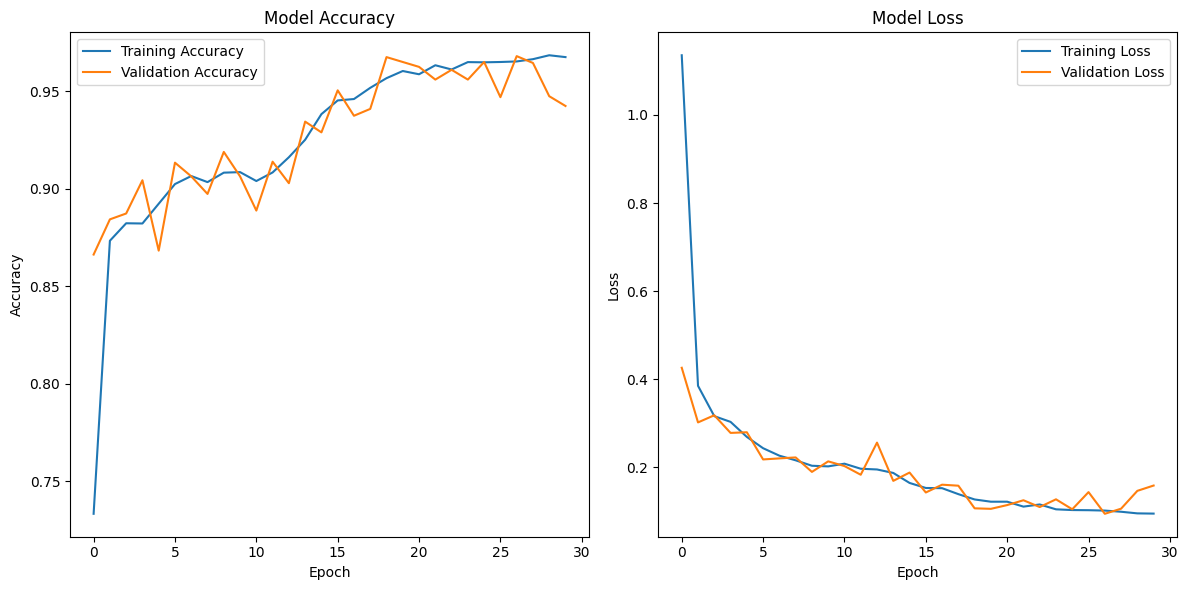

In [ ]:
# new lstm according to this features
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# --- 1. Parameters ---
# UPDATED file name
CSV_FILE = 'uav_dataset_realistic_25k_64beams.csv'
SEQUENCE_LENGTH = 10  # Use 10 past timesteps to predict the next one
NUM_BEAMS = 64

# --- 2. Define Features and Label ---
# UPDATED features list
FEATURES = [
    'Pos_x', 'Pos_y', 'Pos_z',
    'Vel_x', 'Vel_y', 'Vel_z',
    'RSSI_dBm', 'SINR_dB', 'Interference_Power_dBm',
    'Doppler_Shift_Hz', 'AoA_Azimuth_rad', 'AoA_Elevation_rad',
    'RB_Allocation',
    'Is_LoS', 'Fading_Gain_dB' # <-- NEW FEATURES
]
# Label (y)
LABEL = 'Optimal_Beam_Index'

def create_sequences(features_data, labels_data, sequence_length):
    """
    Creates time-series sequences for a single UAV.
    """
    X_seq, y_seq = [], []
    for i in range(len(features_data) - sequence_length):
        X_seq.append(features_data[i:(i + sequence_length)])
        y_seq.append(labels_data[i + sequence_length - 1])
    return np.array(X_seq), np.array(y_seq)

def plot_history(history):
    """Plots training history."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- 3. Load and Preprocess Data ---
print(f"Loading data from {CSV_FILE}...")
try:
    df = pd.read_csv(CSV_FILE)
except FileNotFoundError:
    print(f"Error: {CSV_FILE} not found.")
    exit()

# Handle placeholders from simulation
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(-999, inplace=True)

# Scale features
scaler = MinMaxScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

all_X_seq, all_y_seq = [], []

print("Creating sequences for each UAV...")
for uav_id in df['UAV_ID'].unique():
    uav_df = df[df['UAV_ID'] == uav_id].copy()
    uav_features = uav_df[FEATURES].values
    uav_labels = uav_df[LABEL].values

    X_uav, y_uav = create_sequences(uav_features, uav_labels, SEQUENCE_LENGTH)

    if len(X_uav) > 0:
        all_X_seq.append(X_uav)
        all_y_seq.append(y_uav)

X_total = np.concatenate(all_X_seq, axis=0)
y_total = np.concatenate(all_y_seq, axis=0)

print(f"Total sequences created: {X_total.shape[0]}")

# --- 4. Split Data ---
# Stratify helps with imbalanced datasets (if some beams are rarer)
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_total, test_size=0.2, random_state=42, stratify=y_total
)
print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes:  X={X_test.shape}, y={y_test.shape}")

# --- 5. Build LSTM Model (Classification) ---
model = Sequential()
model.add(LSTM(64, input_shape=(SEQUENCE_LENGTH, len(FEATURES)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(NUM_BEAMS, activation='softmax')) # 64-class output

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

# --- 6. Train Model ---
print("\nStarting model training (Beam Prediction - Realistic Data)...")
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1
)

# --- 7. Evaluate Model ---
print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")
print("\nNOTE: Expect this accuracy to be LOWER than the simple dataset.")
print("This is the new, more realistic baseline.")

plot_history(history)

Loading data from uav_dataset_realistic_25k_64beams.csv...
Creating sequences for each UAV...
Total sequences created: 24945
Train shapes: X=(19956, 10, 16), y=(19956,)
Test shapes:  X=(4989, 10, 16), y=(4989,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 10, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,185 (129.63 KB)

 Trainable params: 33,185 (129.63 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training (SINR Prediction - Realistic Data)...
Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0197 - mae: 0.0986 - val_loss: 0.0029 - val_mae: 0.0359
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0060 - mae: 0.0565 - val_loss: 0.0027 - val_mae: 0.0336
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0053 - mae: 0.0527 - val_loss: 0.0029 - val_mae: 0.0354
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0050 - mae: 0.0509 - val_loss: 0.0027 - val_mae: 0.0359
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0044 - mae: 0.0472 - val_loss: 0.0030 - val_mae: 0.0393
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0045 - mae: 0.0466 - val_loss: 0.0026 - val_mae: 0.0336
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0040 - mae: 0.0434 - val_loss: 0.0026 - val_mae: 0.0347
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0038 - mae: 0.0424 - val_loss: 0.0026 - val_mae: 

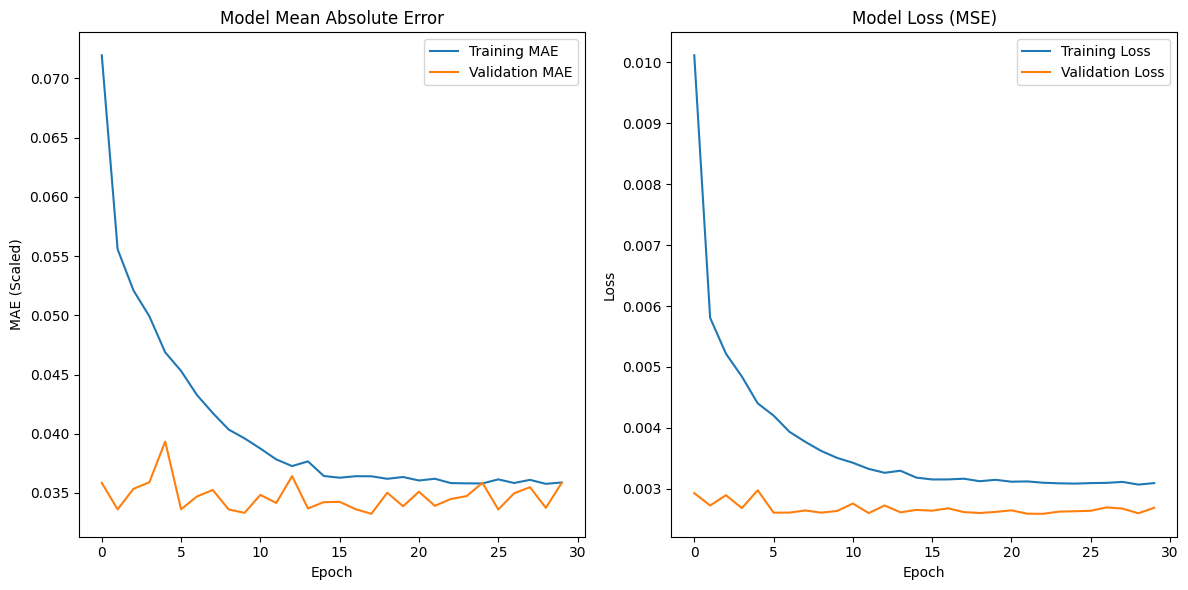


Making predictions on a few test samples...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Predicted vs Actual SINR (in dB):
  Predicted: 6.45 dB  |  Actual: 7.46 dB
  Predicted: -7.54 dB  |  Actual: -7.03 dB
  Predicted: -6.98 dB  |  Actual: -7.19 dB
  Predicted: -4.34 dB  |  Actual: 4.71 dB
  Predicted: -7.35 dB  |  Actual: -0.38 dB


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# --- 1. Parameters ---
# UPDATED file name
CSV_FILE = 'uav_dataset_realistic_25k_64beams.csv'
SEQUENCE_LENGTH = 10  # Use 10 past timesteps to predict the next one

# --- 2. Define Features and Label ---
# UPDATED features list
FEATURES = [
    'Pos_x', 'Pos_y', 'Pos_z',
    'Vel_x', 'Vel_y', 'Vel_z',
    'RSSI_dBm', 'SINR_dB', 'Interference_Power_dBm',
    'Doppler_Shift_Hz', 'AoA_Azimuth_rad', 'AoA_Elevation_rad',
    'RB_Allocation', 'Optimal_Beam_Index',
    'Is_LoS', 'Fading_Gain_dB' # <-- NEW FEATURES
]
# Label (y)
LABEL = 'Predicted_SINR_dB' # This was generated by the new script

def create_sequences(features_data, labels_data, sequence_length):
    """
    Creates time-series sequences for a single UAV.
    """
    X_seq, y_seq = [], []
    for i in range(len(features_data) - sequence_length):
        X_seq.append(features_data[i:(i + sequence_length)])
        y_seq.append(labels_data[i + sequence_length - 1])
    return np.array(X_seq), np.array(y_seq)

def plot_history(history):
    """Plots training history."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.ylabel('MAE (Scaled)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- 3. Load and Preprocess Data ---
print(f"Loading data from {CSV_FILE}...")
try:
    df = pd.read_csv(CSV_FILE)
except FileNotFoundError:
    print(f"Error: {CSV_FILE} not found.")
    exit()

# Handle placeholders from simulation
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(-999, inplace=True)

# Drop rows where the label is a placeholder (the last timestep for each UAV)
df = df[df[LABEL] != -999].copy()

# Scale features AND the label for regression
scaler_features = MinMaxScaler()
scaler_label = MinMaxScaler()

df[FEATURES] = scaler_features.fit_transform(df[FEATURES])
df[LABEL] = scaler_label.fit_transform(df[[LABEL]])

all_X_seq, all_y_seq = [], []

print("Creating sequences for each UAV...")
for uav_id in df['UAV_ID'].unique():
    uav_df = df[df['UAV_ID'] == uav_id].copy()
    uav_features = uav_df[FEATURES].values
    uav_labels = uav_df[LABEL].values

    X_uav, y_uav = create_sequences(uav_features, uav_labels, SEQUENCE_LENGTH)

    if len(X_uav) > 0:
        all_X_seq.append(X_uav)
        all_y_seq.append(y_uav)

X_total = np.concatenate(all_X_seq, axis=0)
y_total = np.concatenate(all_y_seq, axis=0)

print(f"Total sequences created: {X_total.shape[0]}")

# --- 4. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_total, test_size=0.2, random_state=42
)
print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes:  X={X_test.shape}, y={y_test.shape}")

# --- 5. Build LSTM Model (Regression) ---
model = Sequential()
model.add(LSTM(64, input_shape=(SEQUENCE_LENGTH, len(FEATURES)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear')) # 1-neuron output for regression

model.compile(
    loss='mean_squared_error', # MSE for regression
    optimizer='adam',
    metrics=['mae'] # Mean Absolute Error
)
model.summary()

# --- 6. Train Model ---
print("\nStarting model training (SINR Prediction - Realistic Data)...")
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1
)

# --- 7. Evaluate Model ---
print("\nEvaluating model on test data...")
loss_mse, loss_mae = model.evaluate(X_test, y_test)

print(f"Test Mean Absolute Error (MAE): {loss_mae:.4f} (scaled)")
print(f"Test Loss (MSE): {loss_mse:.4f}")
print("\nNOTE: This MAE will likely be higher (worse) than the simple dataset.")
print("The data is 'noisier' and harder to predict.")

plot_history(history)

# --- 8. Make Predictions ---
print("\nMaking predictions on a few test samples...")
predictions_scaled = model.predict(X_test[:5])
predictions_db = scaler_label.inverse_transform(predictions_scaled)

actual_scaled = y_test[:5].reshape(-1, 1)
actual_db = scaler_label.inverse_transform(actual_scaled)

print("Predicted vs Actual SINR (in dB):")
for pred, act in zip(predictions_db, actual_db):
    print(f"  Predicted: {pred[0]:.2f} dB  |  Actual: {act[0]:.2f} dB")

In [ ]:
# Now performing GNN to check wheather independent uav will perform better or we can train interference model better

In [ ]:
# Assuming you have Python and PyTorch installed
!pip install torch_geometric networkx pandas numpy tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, ReLU, Sequential as TorchSequential # Standard PyTorch layers
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, Sequential # PyG Sequential for graph data
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# --- 1. GNN Data Preparation ---

CSV_FILE = '/content/uav_dataset_realistic_25k_64beams.csv'
NUM_UAVS = 5
NUM_BEAMS = 64

# New, combined feature list
# --- 1. CORRECTED FEATURE LIST (Removed 'Optimal_Beam_Index') ---
FEATURES = [
    'Pos_x', 'Pos_y', 'Pos_z',
    'Vel_x', 'Vel_y', 'Vel_z',
    'RSSI_dBm', 'SINR_dB', 'Interference_Power_dBm',
    'Doppler_Shift_Hz', 'AoA_Azimuth_rad', 'AoA_Elevation_rad',
    'RB_Allocation',
    # 'Optimal_Beam_Index', <--- REMOVED (This was the leak)
    'Is_LoS', 'Fading_Gain_dB'
]

# --- 2. CORRECTED DATA LOADING (With Target Scaling) ---
def load_and_prepare_data(csv_file, features):
    print(f"Loading {csv_file}...")
    try:
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"Error: File '{csv_file}' not found.")
        return None, None, None # Return scalers too

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(-999, inplace=True)

    # Drop the last timestep
    df_cleaned = df[df['Predicted_SINR_dB'] != -999].copy()

    # Scale FEATURES (Inputs)
    feature_scaler = MinMaxScaler()
    df_cleaned[features] = feature_scaler.fit_transform(df_cleaned[features])

    # Scale TARGETS (SINR Label) - This fixes the huge MSE error
    target_scaler = MinMaxScaler()
    # We need to reshape to 2D array for the scaler
    sinr_values = df_cleaned['Predicted_SINR_dB'].values.reshape(-1, 1)
    df_cleaned['Predicted_SINR_dB_Scaled'] = target_scaler.fit_transform(sinr_values)

    return df_cleaned, feature_scaler, target_scaler

def create_graph_data(df):
    """Converts the flat DataFrame into a list of PyG Data objects."""
    graph_list = []
    print("Converting data to graph structures...")

    for t, group in tqdm(df.groupby('Timestamp')):
        if len(group) != NUM_UAVS:
            continue

        # 1. Node Features (X) [5, 16]
        x = torch.tensor(group[FEATURES].values, dtype=torch.float)

        # 2. Edge Index (Fully connected graph for 5 UAVs)
        sources, targets = [], []
        for i in range(NUM_UAVS):
            for j in range(NUM_UAVS):
                if i != j:
                    sources.append(i)
                    targets.append(j)
        edge_index = torch.tensor([sources, targets], dtype=torch.long)

        # 3. Edge Attributes (Weight = 1/Distance)
        uav_pos = group[['Pos_x', 'Pos_y', 'Pos_z']].values
        edge_attr_list = []
        for i, j in zip(sources, targets):
            distance = np.linalg.norm(uav_pos[i] - uav_pos[j])
            # Add small epsilon to avoid division by zero
            edge_attr_list.append(1.0 / (distance + 1e-6))

        edge_attr = torch.tensor(edge_attr_list, dtype=torch.float).unsqueeze(1)

        # 4. Labels
        y_beam = torch.tensor(group['Optimal_Beam_Index'].values, dtype=torch.long)
        y_sinr = torch.tensor(group['Predicted_SINR_dB_Scaled'].values, dtype=torch.float).unsqueeze(1)
        graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y_beam=y_beam, y_sinr=y_sinr)
        graph_list.append(graph)

    return graph_list

# --- 2. GAT Model Definition ---

from torch_geometric.nn import GATv2Conv, Sequential

class MultiTaskGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(MultiTaskGNN, self).__init__()

        # --- CHANGE 1: Use GATv2Conv instead of GCNConv ---
        # heads=4: Uses 4 parallel attention mechanisms (like Transformer) to learn better features
        # edge_dim=1: Tells the layer to EXPECT edge weights (our 1/distance feature)
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=4, concat=True, edge_dim=1)

        # Input to conv2 is hidden_channels * heads (because concat=True)
        self.conv2 = GATv2Conv(hidden_channels * 4, hidden_channels, heads=1, concat=False, edge_dim=1)

        # Heads remain similar
        self.beam_head = Sequential('x', [
            (Linear(hidden_channels, hidden_channels), 'x -> x'),
            (ReLU(), 'x -> x'),
            (Linear(hidden_channels, num_classes), 'x -> x')
        ])

        self.sinr_head = Sequential('x', [
            (Linear(hidden_channels, hidden_channels), 'x -> x'),
            (ReLU(), 'x -> x'),
            (Linear(hidden_channels, 1), 'x -> x')
        ])

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # --- CHANGE 2: Pass edge_attr to the layers ---
        x = self.conv1(x, edge_index, edge_attr=edge_attr).relu()
        x = self.conv2(x, edge_index, edge_attr=edge_attr).relu()

        y_beam_pred = self.beam_head(x)
        y_sinr_pred = self.sinr_head(x)

        return y_beam_pred, y_sinr_pred

# --- 3. EXECUTION ---

# --- 3. EXECUTION ---

if __name__ == '__main__':
    # FIX: Unpack all 3 return values.
    # We store the scalers in case we want to inverse transform later.
    df_data, feature_scaler, target_scaler = load_and_prepare_data(CSV_FILE, FEATURES)

    if df_data is not None:
        graph_data_list = create_graph_data(df_data)

        # Split Data
        train_size = int(0.8 * len(graph_data_list))
        train_data = graph_data_list[:train_size]
        test_data = graph_data_list[train_size:]

        # Create DataLoaders
        train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

        # Initialize Model
        model = MultiTaskGNN(in_channels=len(FEATURES), hidden_channels=64, num_classes=NUM_BEAMS)

        # Optimizer and Loss
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        loss_beam_fn = torch.nn.CrossEntropyLoss()
        loss_sinr_fn = torch.nn.MSELoss()

        print(f"\nModel Initialized with {len(FEATURES)} input features.")
        print("Starting Training...")

        # Training Loop
        model.train()
        for epoch in range(1, 31):
            total_loss = 0
            for data in train_loader:
                optimizer.zero_grad()

                # Forward pass
                y_beam_pred, y_sinr_pred = model(data)

                # Calculate losses
                loss_beam = loss_beam_fn(y_beam_pred, data.y_beam)
                loss_sinr = loss_sinr_fn(y_sinr_pred, data.y_sinr)

                loss = loss_beam + loss_sinr
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * data.num_graphs

            avg_loss = total_loss / len(train_loader.dataset)
            print(f'Epoch: {epoch:03d}, Avg Loss: {avg_loss:.4f}')

        print("\nTraining Complete.")

        # --- Run Evaluation ---
        print("\n--- Evaluating on Test Data ---")
        test_acc, test_mse, test_mae = evaluate_model(test_loader)

        print(f"GNN Test Accuracy (Beam Prediction): {test_acc*100:.2f}%")
        # Note: These error numbers are SCALED (between 0 and 1).
        # A generic rough conversion is approx MAE * 40dB range = actual dB error
        print(f"GNN Test MAE (Scaled SINR):          {test_mae:.4f}")
        print(f"GNN Test MSE (Scaled SINR):          {test_mse:.4f}")

Loading /content/uav_dataset_realistic_25k_64beams.csv...
Converting data to graph structures...


100%|██████████| 4999/4999 [00:07<00:00, 632.19it/s]
/tmp/ipython-input-487224920.py:153: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
/tmp/ipython-input-487224920.py:154: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_data, batch_size=32, shuffle=False)



Model Initialized with 15 input features.
Starting Training...
Epoch: 001, Avg Loss: 1.7121
Epoch: 002, Avg Loss: 0.8976
Epoch: 003, Avg Loss: 0.6268
Epoch: 004, Avg Loss: 0.3591
Epoch: 005, Avg Loss: 0.2190
Epoch: 006, Avg Loss: 0.1585
Epoch: 007, Avg Loss: 0.1419
Epoch: 008, Avg Loss: 0.1220
Epoch: 009, Avg Loss: 0.1117
Epoch: 010, Avg Loss: 0.1041
Epoch: 011, Avg Loss: 0.0903
Epoch: 012, Avg Loss: 0.1335
Epoch: 013, Avg Loss: 0.0892
Epoch: 014, Avg Loss: 0.0692
Epoch: 015, Avg Loss: 0.0751
Epoch: 016, Avg Loss: 0.0754
Epoch: 017, Avg Loss: 0.0603
Epoch: 018, Avg Loss: 0.0643
Epoch: 019, Avg Loss: 0.0693
Epoch: 020, Avg Loss: 0.0871
Epoch: 021, Avg Loss: 0.0621
Epoch: 022, Avg Loss: 0.0599
Epoch: 023, Avg Loss: 0.0603
Epoch: 024, Avg Loss: 0.0588
Epoch: 025, Avg Loss: 0.0498
Epoch: 026, Avg Loss: 0.0616
Epoch: 027, Avg Loss: 0.0593
Epoch: 028, Avg Loss: 0.0607
Epoch: 029, Avg Loss: 0.0501
Epoch: 030, Avg Loss: 0.0579

Training Complete.

--- Evaluating on Test Data ---
GNN Test Accu

In [ ]:
# test dataset 2 (HIGH SPEED DATA)

In [ ]:

import numpy as np
import pandas as pd
import warnings
from tqdm import trange

# --- CONFIGURATION FOR HIGH SPEED ---
# We simply reuse the exact same logic but tweak the mobility parameters
OUTPUT_FILENAME = 'uav_dataset_high_speed.csv'
VELOCITY_VARIANCE = 25.0  # <--- INCREASED from 5.0 to 25.0 (Much faster UAVs)
VELOCITY_UPDATE = 0.95    # <--- INCREASED momentum to sustain high speeds

# --- COPY OF REQUISITE FUNCTIONS (Condensed for brevity) ---
# (These are identical to the previous step)
def get_los_probability(elevation_angle_deg):
    if elevation_angle_deg < 0: return 0.0
    p1, p2 = 0.95, 0.08
    return min(p1 * (1 - np.exp(-p2 * elevation_angle_deg)), 1.0)

def get_fading_gain_db(is_los, k_factor_db=10):
    if is_los:
        K = 10**(k_factor_db / 10)
        h = np.sqrt(K/(K+1))*(np.random.normal(1,0)+1j*0) + np.sqrt(1/(K+1)/2)*(np.random.normal(0,1,1)+1j*np.random.normal(0,1,1))
        return 10 * np.log10(np.abs(h)**2)[0]
    else:
        h = np.sqrt(0.5)*(np.random.normal(0,1,1)+1j*np.random.normal(0,1,1))
        return 10 * np.log10(np.abs(h)**2)[0]

def calculate_antenna_gain_db(target_vec, beam_vec, main_lobe=20, sidelobe=-10, width=45):
    dot = np.clip(np.dot(target_vec, beam_vec), -1.0, 1.0)
    deg = np.degrees(np.arccos(dot))
    return main_lobe if deg <= (width/2) else sidelobe

def create_beam_codebook():
    vecs = []
    idx = 0
    for az in np.linspace(-np.pi, np.pi, 8, endpoint=False):
        for el in np.linspace(-np.pi/2, np.pi/2, 10)[1:-1]:
            vecs.append((idx, np.array([np.cos(el)*np.cos(az), np.cos(el)*np.sin(az), np.sin(el)])))
            idx += 1
    return vecs

def find_optimal_beam(true_aoa, codebook):
    best_idx, best_vec, max_dot = -1, None, -np.inf
    for idx, vec in codebook:
        dot = np.dot(true_aoa, vec)
        if dot > max_dot: max_dot, best_idx, best_vec = dot, idx, vec
    return best_idx, best_vec

# --- MAIN GENERATOR ---
def generate_high_speed_dataset(num_uavs=5, num_timesteps=5000):
    print(f"Generating HIGH SPEED dataset ({VELOCITY_VARIANCE} variance)...")

    # Setup
    bs_pos = np.array([0, 0, 25])
    beam_codebook = create_beam_codebook()

    # Data storage
    columns = ['UAV_ID', 'Timestamp', 'Pos_x', 'Pos_y', 'Pos_z', 'Vel_x', 'Vel_y', 'Vel_z',
               'RSSI_dBm', 'SINR_dB', 'Interference_Power_dBm', 'Channel_Gain_dB',
               'Fading_Gain_dB', 'Doppler_Shift_Hz', 'AoA_Azimuth_rad', 'AoA_Elevation_rad',
               'RB_Allocation', 'Tx_Power_dBm', 'Interference_Event_Flag',
               'Optimal_Beam_Index', 'Is_LoS']
    data = np.zeros((num_uavs * num_timesteps, len(columns)))

    # Init State
    uav_pos = np.random.rand(num_uavs, 3) * 1000 - 500
    uav_pos[:, 2] = np.random.uniform(50, 150, num_uavs)
    uav_vel = np.random.normal(0, VELOCITY_VARIANCE, (num_uavs, 3)) # High initial speed

    df_list = []

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for t in trange(num_timesteps):
            current_rbs = np.random.randint(1, 6, num_uavs)
            ts_data = []

            # Pass 1: Physics
            for u in range(num_uavs):
                # High Speed Update
                uav_vel[u] = (VELOCITY_UPDATE * uav_vel[u] +
                              (1 - VELOCITY_UPDATE) * np.random.normal(0, VELOCITY_VARIANCE, 3))
                uav_pos[u] += uav_vel[u] * 0.1

                vec = bs_pos - uav_pos[u]
                dist = np.linalg.norm(vec)
                dist_km = dist/1000 if dist > 1 else 0.001

                # Angles & LoS
                el_deg = np.degrees(np.arcsin(vec[2]/dist))
                is_los = np.random.rand() < get_los_probability(el_deg)

                # Path Loss
                pl = (32.4 + 20*np.log10(dist_km)) if is_los else (35.3 + 37.6*np.log10(dist_km))
                fading = get_fading_gain_db(is_los)
                ch_gain = -pl + fading

                # Beam
                best_idx, best_vec = find_optimal_beam(vec/dist, beam_codebook)

                # Doppler
                dop = (np.dot(uav_vel[u], vec)/dist * 3.5e9) / 3e8

                ts_data.append({
                    'id': u, 'pos': uav_pos[u], 'vel': uav_vel[u], 'vec': vec/dist,
                    'rssi': 23 + ch_gain + 20, 'beam_vec': best_vec, 'rb': current_rbs[u],
                    'row': [u+1, t*0.1, *uav_pos[u], *uav_vel[u], 23+ch_gain+20, 0, 0, ch_gain,
                            fading, dop, np.arctan2(vec[1], vec[0]), np.arcsin(vec[2]/dist),
                            current_rbs[u], 23, 0, best_idx, int(is_los)]
                })

            # Pass 2: Interference
            for u in range(num_uavs):
                me = ts_data[u]
                interf_lin = 0.0
                for other in range(num_uavs):
                    if u != other and me['rb'] == ts_data[other]['rb']:
                        them = ts_data[other]
                        # Calculate gain of MY beam on THEIR position
                        gain = calculate_antenna_gain_db(them['vec'], me['beam_vec'])
                        # Their base power (RSSI - MainLobeGain) + My Sidelobe Gain
                        interf_lin += 10**((them['rssi'] - 20 + gain)/10)

                interf_dbm = 10*np.log10(interf_lin) if interf_lin > 0 else -120
                sinr = 10*np.log10(10**(me['rssi']/10) / (interf_lin + 10**(-11.4)))

                me['row'][9] = sinr # Update SINR
                me['row'][10] = interf_dbm
                me['row'][18] = 1 if sinr < 5 else 0

                df_list.append(me['row'])

    df = pd.DataFrame(df_list, columns=columns)

    # Labels
    df['Predicted_SINR_dB'] = df.groupby('UAV_ID')['SINR_dB'].shift(-1)
    df.fillna(-999, inplace=True)

    df.to_csv(OUTPUT_FILENAME, index=False)
    print(f"Saved to {OUTPUT_FILENAME}")

    # Velocity Check
    speeds = np.sqrt(df['Vel_x']**2 + df['Vel_y']**2 + df['Vel_z']**2)
    print(f"Average Speed: {speeds.mean():.2f} m/s (Max: {speeds.max():.2f} m/s)")

if __name__ == "__main__":
    generate_high_speed_dataset()

Generating HIGH SPEED dataset (25.0 variance)...


100%|██████████| 5000/5000 [00:08<00:00, 600.57it/s]


Saved to uav_dataset_high_speed.csv
Average Speed: 6.38 m/s (Max: 66.35 m/s)


In [ ]:
# new lstm according to this features
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# --- 1. Parameters ---
# UPDATED file name
CSV_FILE = '/content/uav_dataset_high_speed.csv'
SEQUENCE_LENGTH = 10  # Use 10 past timesteps to predict the next one
NUM_BEAMS = 64

# --- 2. Define Features and Label ---
# UPDATED features list
FEATURES = [
    'Pos_x', 'Pos_y', 'Pos_z',
    'Vel_x', 'Vel_y', 'Vel_z',
    'RSSI_dBm', 'SINR_dB', 'Interference_Power_dBm',
    'Doppler_Shift_Hz', 'AoA_Azimuth_rad', 'AoA_Elevation_rad',
    'RB_Allocation',
    'Is_LoS', 'Fading_Gain_dB' # <-- NEW FEATURES
]
# Label (y)
LABEL = 'Optimal_Beam_Index'

def create_sequences(features_data, labels_data, sequence_length):
    """
    Creates time-series sequences for a single UAV.
    """
    X_seq, y_seq = [], []
    for i in range(len(features_data) - sequence_length):
        X_seq.append(features_data[i:(i + sequence_length)])
        y_seq.append(labels_data[i + sequence_length - 1])
    return np.array(X_seq), np.array(y_seq)

def plot_history(history):
    """Plots training history."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- 3. Load and Preprocess Data ---
print(f"Loading data from {CSV_FILE}...")
try:
    df = pd.read_csv(CSV_FILE)
except FileNotFoundError:
    print(f"Error: {CSV_FILE} not found.")
    exit()

# Handle placeholders from simulation
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(-999, inplace=True)

# Scale features
scaler = MinMaxScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

all_X_seq, all_y_seq = [], []

print("Creating sequences for each UAV...")
for uav_id in df['UAV_ID'].unique():
    uav_df = df[df['UAV_ID'] == uav_id].copy()
    uav_features = uav_df[FEATURES].values
    uav_labels = uav_df[LABEL].values

    X_uav, y_uav = create_sequences(uav_features, uav_labels, SEQUENCE_LENGTH)

    if len(X_uav) > 0:
        all_X_seq.append(X_uav)
        all_y_seq.append(y_uav)

X_total = np.concatenate(all_X_seq, axis=0)
y_total = np.concatenate(all_y_seq, axis=0)

print(f"Total sequences created: {X_total.shape[0]}")

# --- 4. Split Data ---
# Stratify helps with imbalanced datasets (if some beams are rarer)
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_total, test_size=0.2, random_state=42, stratify=y_total
)
print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes:  X={X_test.shape}, y={y_test.shape}")

# --- 5. Build LSTM Model (Classification) ---
model = Sequential()
model.add(LSTM(64, input_shape=(SEQUENCE_LENGTH, len(FEATURES)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(NUM_BEAMS, activation='softmax')) # 64-class output

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

# --- 6. Train Model ---
print("\nStarting model training (Beam Prediction - Realistic Data)...")
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1
)

# --- 7. Evaluate Model ---
print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")
print("\nNOTE: Expect this accuracy to be LOWER than the simple dataset.")
print("This is the new, more realistic baseline.")

plot_history(history)

Loading data from /content/uav_dataset_high_speed.csv...
Creating sequences for each UAV...
Total sequences created: 24950
Train shapes: X=(19960, 10, 15), y=(19960,)
Test shapes:  X=(4990, 10, 15), y=(4990,)


KeyboardInterrupt: 

Loading data from /content/uav_dataset_high_speed.csv...
Creating sequences for each UAV...
Total sequences created: 24945
Train shapes: X=(19956, 10, 16), y=(19956,)
Test shapes:  X=(4989, 10, 16), y=(4989,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 10, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,185 (129.63 KB)

 Trainable params: 33,185 (129.63 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training (SINR Prediction - Realistic Data)...
Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1152 - mae: 0.2992 - val_loss: 0.0871 - val_mae: 0.2813
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0890 - mae: 0.2824 - val_loss: 0.0867 - val_mae: 0.2889
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0885 - mae: 0.2842 - val_loss: 0.0863 - val_mae: 0.2873
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0881 - mae: 0.2831 - val_loss: 0.0868 - val_mae: 0.2807
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0875 - mae: 0.2828 - val_loss: 0.0876 - val_mae: 0.2779
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0878 - mae: 0.2842 - val_loss: 0.0864 - val_mae: 0.2890
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0873 - mae: 0.2835 - val_loss: 0.0865 - val_mae: 0.2810
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0867 - mae: 0.2828 - val_loss: 0.0864 - val_mae:

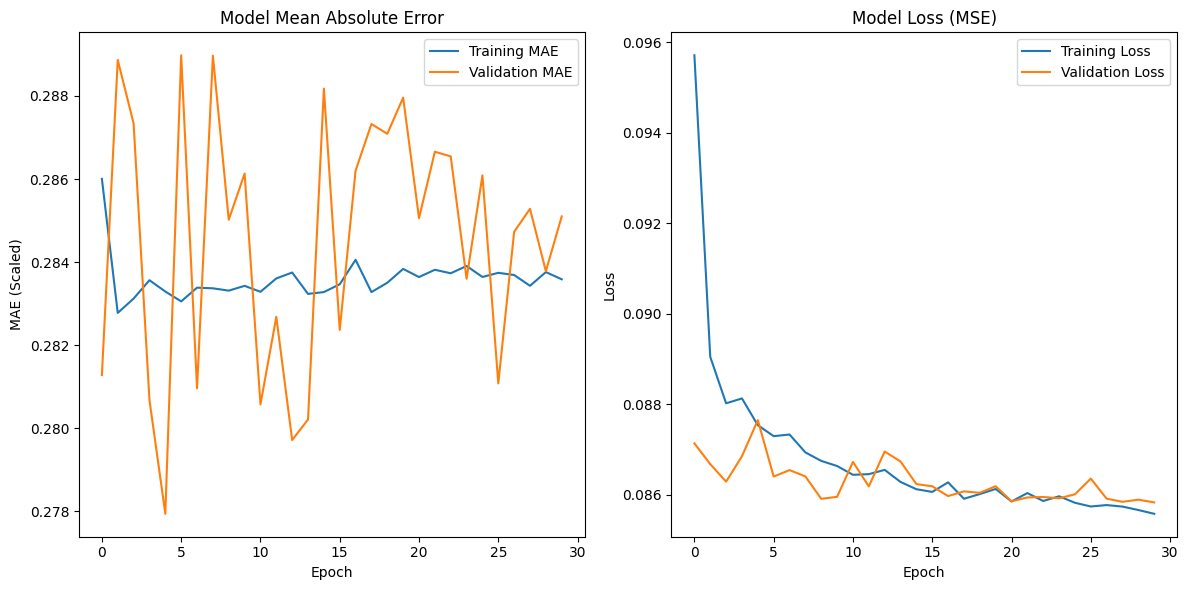


Making predictions on a few test samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Predicted vs Actual SINR (in dB):
  Predicted: 66.76 dB  |  Actual: 23.50 dB
  Predicted: 74.18 dB  |  Actual: 34.20 dB
  Predicted: 79.32 dB  |  Actual: 38.57 dB
  Predicted: 83.61 dB  |  Actual: 148.88 dB
  Predicted: 85.26 dB  |  Actual: 44.23 dB


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# --- 1. Parameters ---
# UPDATED file name
CSV_FILE = '/content/uav_dataset_high_speed.csv'
SEQUENCE_LENGTH = 10  # Use 10 past timesteps to predict the next one

# --- 2. Define Features and Label ---
# UPDATED features list
FEATURES = [
    'Pos_x', 'Pos_y', 'Pos_z',
    'Vel_x', 'Vel_y', 'Vel_z',
    'RSSI_dBm', 'SINR_dB', 'Interference_Power_dBm',
    'Doppler_Shift_Hz', 'AoA_Azimuth_rad', 'AoA_Elevation_rad',
    'RB_Allocation', 'Optimal_Beam_Index',
    'Is_LoS', 'Fading_Gain_dB' # <-- NEW FEATURES
]
# Label (y)
LABEL = 'Predicted_SINR_dB' # This was generated by the new script

def create_sequences(features_data, labels_data, sequence_length):
    """
    Creates time-series sequences for a single UAV.
    """
    X_seq, y_seq = [], []
    for i in range(len(features_data) - sequence_length):
        X_seq.append(features_data[i:(i + sequence_length)])
        y_seq.append(labels_data[i + sequence_length - 1])
    return np.array(X_seq), np.array(y_seq)

def plot_history(history):
    """Plots training history."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.ylabel('MAE (Scaled)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- 3. Load and Preprocess Data ---
print(f"Loading data from {CSV_FILE}...")
try:
    df = pd.read_csv(CSV_FILE)
except FileNotFoundError:
    print(f"Error: {CSV_FILE} not found.")
    exit()

# Handle placeholders from simulation
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(-999, inplace=True)

# Drop rows where the label is a placeholder (the last timestep for each UAV)
df = df[df[LABEL] != -999].copy()

# Scale features AND the label for regression
scaler_features = MinMaxScaler()
scaler_label = MinMaxScaler()

df[FEATURES] = scaler_features.fit_transform(df[FEATURES])
df[LABEL] = scaler_label.fit_transform(df[[LABEL]])

all_X_seq, all_y_seq = [], []

print("Creating sequences for each UAV...")
for uav_id in df['UAV_ID'].unique():
    uav_df = df[df['UAV_ID'] == uav_id].copy()
    uav_features = uav_df[FEATURES].values
    uav_labels = uav_df[LABEL].values

    X_uav, y_uav = create_sequences(uav_features, uav_labels, SEQUENCE_LENGTH)

    if len(X_uav) > 0:
        all_X_seq.append(X_uav)
        all_y_seq.append(y_uav)

X_total = np.concatenate(all_X_seq, axis=0)
y_total = np.concatenate(all_y_seq, axis=0)

print(f"Total sequences created: {X_total.shape[0]}")

# --- 4. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_total, test_size=0.2, random_state=42
)
print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes:  X={X_test.shape}, y={y_test.shape}")

# --- 5. Build LSTM Model (Regression) ---
model = Sequential()
model.add(LSTM(64, input_shape=(SEQUENCE_LENGTH, len(FEATURES)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear')) # 1-neuron output for regression

model.compile(
    loss='mean_squared_error', # MSE for regression
    optimizer='adam',
    metrics=['mae'] # Mean Absolute Error
)
model.summary()

# --- 6. Train Model ---
print("\nStarting model training (SINR Prediction - Realistic Data)...")
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1
)

# --- 7. Evaluate Model ---
print("\nEvaluating model on test data...")
loss_mse, loss_mae = model.evaluate(X_test, y_test)

print(f"Test Mean Absolute Error (MAE): {loss_mae:.4f} (scaled)")
print(f"Test Loss (MSE): {loss_mse:.4f}")
print("\nNOTE: This MAE will likely be higher (worse) than the simple dataset.")
print("The data is 'noisier' and harder to predict.")

plot_history(history)

# --- 8. Make Predictions ---
print("\nMaking predictions on a few test samples...")
predictions_scaled = model.predict(X_test[:5])
predictions_db = scaler_label.inverse_transform(predictions_scaled)

actual_scaled = y_test[:5].reshape(-1, 1)
actual_db = scaler_label.inverse_transform(actual_scaled)

print("Predicted vs Actual SINR (in dB):")
for pred, act in zip(predictions_db, actual_db):
    print(f"  Predicted: {pred[0]:.2f} dB  |  Actual: {act[0]:.2f} dB")

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, ReLU, Sequential as TorchSequential # Standard PyTorch layers
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, Sequential # PyG Sequential for graph data
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# --- 1. GNN Data Preparation ---

CSV_FILE = '//content/uav_dataset_high_speed.csv'
NUM_UAVS = 5
NUM_BEAMS = 64

# New, combined feature list
# --- 1. CORRECTED FEATURE LIST (Removed 'Optimal_Beam_Index') ---
FEATURES = [
    'Pos_x', 'Pos_y', 'Pos_z',
    'Vel_x', 'Vel_y', 'Vel_z',
    'RSSI_dBm', 'SINR_dB', 'Interference_Power_dBm',
    'Doppler_Shift_Hz', 'AoA_Azimuth_rad', 'AoA_Elevation_rad',
    'RB_Allocation',
    'Is_LoS', 'Fading_Gain_dB'
]

# --- 2. CORRECTED DATA LOADING (With Target Scaling) ---
def load_and_prepare_data(csv_file, features):
    print(f"Loading {csv_file}...")
    try:
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"Error: File '{csv_file}' not found.")
        return None, None, None # Return scalers too

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(-999, inplace=True)

    # Drop the last timestep
    df_cleaned = df[df['Predicted_SINR_dB'] != -999].copy()

    # Scale FEATURES (Inputs)
    feature_scaler = MinMaxScaler()
    df_cleaned[features] = feature_scaler.fit_transform(df_cleaned[features])

    # Scale TARGETS (SINR Label) - This fixes the huge MSE error
    target_scaler = MinMaxScaler()
    # We need to reshape to 2D array for the scaler
    sinr_values = df_cleaned['Predicted_SINR_dB'].values.reshape(-1, 1)
    df_cleaned['Predicted_SINR_dB_Scaled'] = target_scaler.fit_transform(sinr_values)

    return df_cleaned, feature_scaler, target_scaler

def create_graph_data(df):
    """Converts the flat DataFrame into a list of PyG Data objects."""
    graph_list = []
    print("Converting data to graph structures...")

    for t, group in tqdm(df.groupby('Timestamp')):
        if len(group) != NUM_UAVS:
            continue

        # 1. Node Features (X) [5, 16]
        x = torch.tensor(group[FEATURES].values, dtype=torch.float)

        # 2. Edge Index (Fully connected graph for 5 UAVs)
        sources, targets = [], []
        for i in range(NUM_UAVS):
            for j in range(NUM_UAVS):
                if i != j:
                    sources.append(i)
                    targets.append(j)
        edge_index = torch.tensor([sources, targets], dtype=torch.long)

        # 3. Edge Attributes (Weight = 1/Distance)
        uav_pos = group[['Pos_x', 'Pos_y', 'Pos_z']].values
        edge_attr_list = []
        for i, j in zip(sources, targets):
            distance = np.linalg.norm(uav_pos[i] - uav_pos[j])
            # Add small epsilon to avoid division by zero
            edge_attr_list.append(1.0 / (distance + 1e-6))

        edge_attr = torch.tensor(edge_attr_list, dtype=torch.float).unsqueeze(1)

        # 4. Labels
        y_beam = torch.tensor(group['Optimal_Beam_Index'].values, dtype=torch.long)
        y_sinr = torch.tensor(group['Predicted_SINR_dB_Scaled'].values, dtype=torch.float).unsqueeze(1)
        graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y_beam=y_beam, y_sinr=y_sinr)
        graph_list.append(graph)

    return graph_list

# --- 2. GAT Model Definition ---

from torch_geometric.nn import GATv2Conv, Sequential

class MultiTaskGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(MultiTaskGNN, self).__init__()

        # --- CHANGE 1: Use GATv2Conv instead of GCNConv ---
        # heads=4: Uses 4 parallel attention mechanisms (like Transformer) to learn better features
        # edge_dim=1: Tells the layer to EXPECT edge weights (our 1/distance feature)
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=4, concat=True, edge_dim=1)

        # Input to conv2 is hidden_channels * heads (because concat=True)
        self.conv2 = GATv2Conv(hidden_channels * 4, hidden_channels, heads=1, concat=False, edge_dim=1)

        # Heads remain similar
        self.beam_head = Sequential('x', [
            (Linear(hidden_channels, hidden_channels), 'x -> x'),
            (ReLU(), 'x -> x'),
            (Linear(hidden_channels, num_classes), 'x -> x')
        ])

        self.sinr_head = Sequential('x', [
            (Linear(hidden_channels, hidden_channels), 'x -> x'),
            (ReLU(), 'x -> x'),
            (Linear(hidden_channels, 1), 'x -> x')
        ])

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # --- CHANGE 2: Pass edge_attr to the layers ---
        x = self.conv1(x, edge_index, edge_attr=edge_attr).relu()
        x = self.conv2(x, edge_index, edge_attr=edge_attr).relu()

        y_beam_pred = self.beam_head(x)
        y_sinr_pred = self.sinr_head(x)

        return y_beam_pred, y_sinr_pred

# --- 3. EXECUTION ---

# --- 3. EXECUTION ---

if __name__ == '__main__':
    # FIX: Unpack all 3 return values.
    # We store the scalers in case we want to inverse transform later.
    df_data, feature_scaler, target_scaler = load_and_prepare_data(CSV_FILE, FEATURES)

    if df_data is not None:
        graph_data_list = create_graph_data(df_data)

        # Split Data
        train_size = int(0.8 * len(graph_data_list))
        train_data = graph_data_list[:train_size]
        test_data = graph_data_list[train_size:]

        # Create DataLoaders
        train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

        # Initialize Model
        model = MultiTaskGNN(in_channels=len(FEATURES), hidden_channels=64, num_classes=NUM_BEAMS)

        # Optimizer and Loss
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        loss_beam_fn = torch.nn.CrossEntropyLoss()
        loss_sinr_fn = torch.nn.MSELoss()

        print(f"\nModel Initialized with {len(FEATURES)} input features.")
        print("Starting Training...")

        # Training Loop
        model.train()
        for epoch in range(1, 31):
            total_loss = 0
            for data in train_loader:
                optimizer.zero_grad()

                # Forward pass
                y_beam_pred, y_sinr_pred = model(data)

                # Calculate losses
                loss_beam = loss_beam_fn(y_beam_pred, data.y_beam)
                loss_sinr = loss_sinr_fn(y_sinr_pred, data.y_sinr)

                loss = loss_beam + loss_sinr
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * data.num_graphs

            avg_loss = total_loss / len(train_loader.dataset)
            print(f'Epoch: {epoch:03d}, Avg Loss: {avg_loss:.4f}')

        print("\nTraining Complete.")

        # --- Run Evaluation ---
        print("\n--- Evaluating on Test Data ---")
        test_acc, test_mse, test_mae = evaluate_model(test_loader)

        print(f"GNN Test Accuracy (Beam Prediction): {test_acc*100:.2f}%")
        # Note: These error numbers are SCALED (between 0 and 1).
        # A generic rough conversion is approx MAE * 40dB range = actual dB error
        print(f"GNN Test MAE (Scaled SINR):          {test_mae:.4f}")
        print(f"GNN Test MSE (Scaled SINR):          {test_mse:.4f}")

Loading //content/uav_dataset_high_speed.csv...
Converting data to graph structures...


100%|██████████| 4999/4999 [00:08<00:00, 587.65it/s]
/tmp/ipython-input-100034970.py:152: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
/tmp/ipython-input-100034970.py:153: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_data, batch_size=32, shuffle=False)



Model Initialized with 15 input features.
Starting Training...
Epoch: 001, Avg Loss: 2.6724
Epoch: 002, Avg Loss: 1.4386
Epoch: 003, Avg Loss: 1.0593
Epoch: 004, Avg Loss: 0.7956
Epoch: 005, Avg Loss: 0.6728
Epoch: 006, Avg Loss: 0.5274
Epoch: 007, Avg Loss: 0.4723
Epoch: 008, Avg Loss: 0.4411
Epoch: 009, Avg Loss: 0.4059
Epoch: 010, Avg Loss: 0.3824
Epoch: 011, Avg Loss: 0.3689
Epoch: 012, Avg Loss: 0.3714
Epoch: 013, Avg Loss: 0.3254
Epoch: 014, Avg Loss: 0.3511
Epoch: 015, Avg Loss: 0.3119
Epoch: 016, Avg Loss: 0.3001
Epoch: 017, Avg Loss: 0.3129
Epoch: 018, Avg Loss: 0.3086
Epoch: 019, Avg Loss: 0.2567
Epoch: 020, Avg Loss: 0.2709
Epoch: 021, Avg Loss: 0.2676
Epoch: 022, Avg Loss: 0.2512
Epoch: 023, Avg Loss: 0.2616
Epoch: 024, Avg Loss: 0.2456
Epoch: 025, Avg Loss: 0.2336
Epoch: 026, Avg Loss: 0.2487
Epoch: 027, Avg Loss: 0.2825
Epoch: 028, Avg Loss: 0.2315
Epoch: 029, Avg Loss: 0.2336
Epoch: 030, Avg Loss: 0.2347

Training Complete.

--- Evaluating on Test Data ---
GNN Test Accu

In [ ]:
# checking about feature importance for both the trained models we have i.e. LSTM and GAN network
# This is being done cause interoperability is low for both

Loading and processing data for LSTM...

Training LSTM (5 Epochs)...
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4447 - loss: 2.0917
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8528 - loss: 0.4571
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9077 - loss: 0.2741
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9167 - loss: 0.2329
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9214 - loss: 0.2141
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9288 - loss: 0.1921
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9409 - loss: 0.1654
Epoch 8/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9382 - loss: 0.1722
Epoch 9/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9399 - loss: 0.1565
Epoch 10/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9472 - loss: 0.1395
Epoch 11/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9531 - loss: 0.1218
Epoch 12/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accurac

/tmp/ipython-input-1137262544.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette='magma')


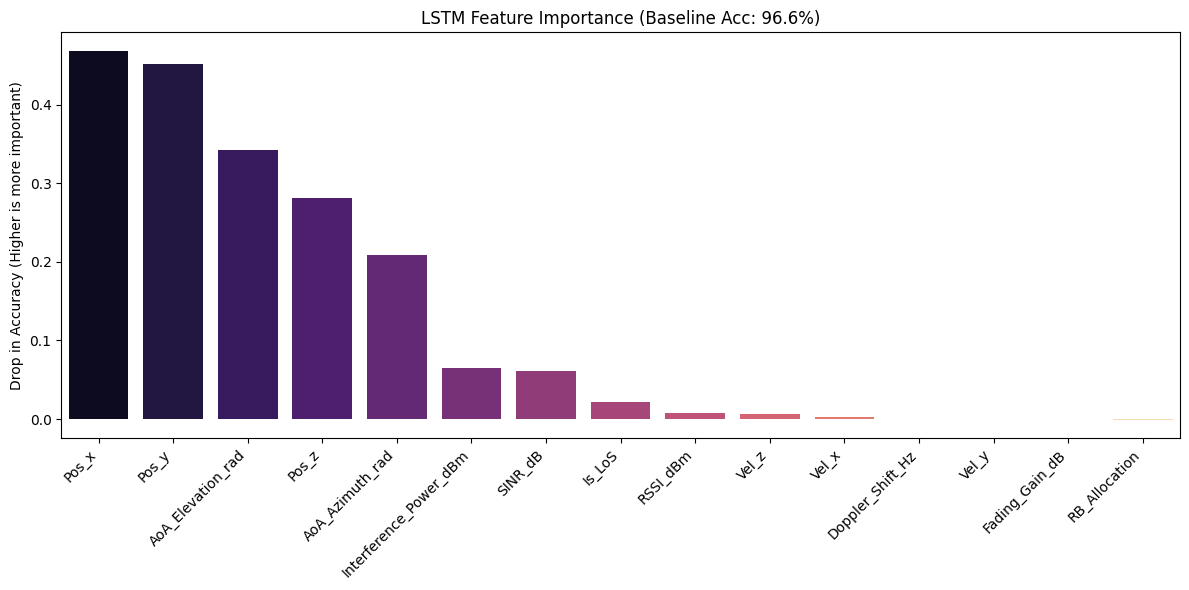

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# --- CONFIGURATION ---
CSV_FILE = 'uav_dataset_high_speed.csv'
SEQUENCE_LENGTH = 10
NUM_BEAMS = 64

# NO LABEL LEAKAGE: 'Optimal_Beam_Index' is NOT in inputs
FEATURES = [
    'Pos_x', 'Pos_y', 'Pos_z',
    'Vel_x', 'Vel_y', 'Vel_z',
    'RSSI_dBm', 'SINR_dB', 'Interference_Power_dBm',
    'Doppler_Shift_Hz', 'AoA_Azimuth_rad', 'AoA_Elevation_rad',
    'RB_Allocation',
    'Is_LoS', 'Fading_Gain_dB'
]

def get_lstm_data(csv_file):
    print("Loading and processing data for LSTM...")
    try:
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"Error: {csv_file} not found.")
        return None, None, None

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(-999, inplace=True)

    # Scale Features
    scaler = MinMaxScaler()
    df[FEATURES] = scaler.fit_transform(df[FEATURES])

    X_seq, y_seq = [], []
    # Create sequences per UAV
    for uav_id in df['UAV_ID'].unique():
        uav_df = df[df['UAV_ID'] == uav_id]
        feat_data = uav_df[FEATURES].values
        # Label: Optimal_Beam_Index
        label_data = uav_df['Optimal_Beam_Index'].values

        for i in range(len(feat_data) - SEQUENCE_LENGTH):
            X_seq.append(feat_data[i : i+SEQUENCE_LENGTH])
            y_seq.append(label_data[i+SEQUENCE_LENGTH-1])

    return np.array(X_seq), np.array(y_seq), scaler

def run_lstm_xai():
    X, y, _ = get_lstm_data(CSV_FILE)
    if X is None: return

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build Model
    model = Sequential([
        LSTM(64, input_shape=(SEQUENCE_LENGTH, len(FEATURES)), return_sequences=False),
        Dropout(0.2),
        Dense(NUM_BEAMS, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print("\nTraining LSTM (30 Epochs)...")
    model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1)

    # 1. Baseline Accuracy
    print("\nCalculating Baseline Accuracy...")
    _, baseline_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Baseline Accuracy: {baseline_acc*100:.2f}%")

    # 2. Permutation Importance
    importance = {}
    print("\nRunning Permutation Importance (shuffling one feature at a time)...")

    for i, feature_name in enumerate(FEATURES):
        # Create copy of test data
        X_corrupted = X_test.copy()

        # Shuffle the specific feature column across all samples and timesteps
        # We flatten, shuffle, and reshape to destroy temporal and sample correlation for this feature
        flat_feat = X_corrupted[:, :, i].flatten()
        np.random.shuffle(flat_feat)
        X_corrupted[:, :, i] = flat_feat.reshape(X_test.shape[0], X_test.shape[1])

        # Evaluate
        _, acc = model.evaluate(X_corrupted, y_test, verbose=0)
        drop = baseline_acc - acc
        importance[feature_name] = drop
        print(f"  {feature_name}: Drop = {drop:.4f}")

    # 3. Plot
    sorted_imp = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    names = [x[0] for x in sorted_imp]
    values = [x[1] for x in sorted_imp]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=names, y=values, palette='magma')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"LSTM Feature Importance (Baseline Acc: {baseline_acc*100:.1f}%)")
    plt.ylabel("Drop in Accuracy (Higher is more important)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_lstm_xai()

Loading data for SINR Regression...

Training LSTM for SINR Prediction (30 Epochs)...
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1091 - mae: 0.2934
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0834 - mae: 0.2759
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0821 - mae: 0.2739
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0820 - mae: 0.2747
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0814 - mae: 0.2745
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0819 - mae: 0.2758
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0809 - mae: 0.2743
Epoch 8/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0815 - mae: 0.2752
Epoch 9/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0809 - mae: 0.2750
Epoch 10/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0806 - mae: 0.2733
Epoch 11/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0806 - mae: 0.2734
Epoch 12/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0806 - mae: 0.2748
Epoch 13/30
312/312 ━━━━━━━━━━━━━

/tmp/ipython-input-1684241464.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette='coolwarm')


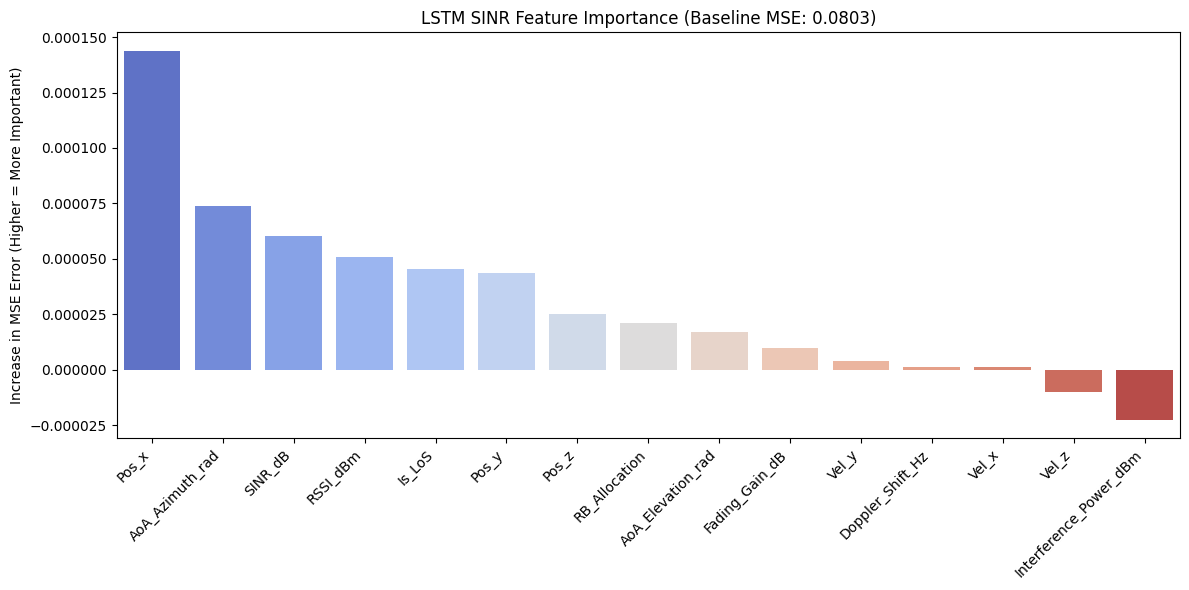

In [ ]:
# this one is interference detection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- CONFIGURATION ---
CSV_FILE = 'uav_dataset_high_speed.csv'
SEQUENCE_LENGTH = 10

# Features (Standard list, no labels)
FEATURES = [
    'Pos_x', 'Pos_y', 'Pos_z',
    'Vel_x', 'Vel_y', 'Vel_z',
    'RSSI_dBm', 'SINR_dB', 'Interference_Power_dBm',
    'Doppler_Shift_Hz', 'AoA_Azimuth_rad', 'AoA_Elevation_rad',
    'RB_Allocation',
    'Is_LoS', 'Fading_Gain_dB'
]

def get_lstm_regression_data(csv_file):
    print("Loading data for SINR Regression...")
    try:
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"Error: {csv_file} not found.")
        return None, None, None, None

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(-999, inplace=True)

    # Drop invalid rows (last timestep where target is missing)
    df = df[df['Predicted_SINR_dB'] != -999].copy()

    # 1. Scale Features
    feat_scaler = MinMaxScaler()
    df[FEATURES] = feat_scaler.fit_transform(df[FEATURES])

    # 2. Scale Target (SINR is continuous, so we must scale it)
    target_scaler = MinMaxScaler()
    sinr_values = df['Predicted_SINR_dB'].values.reshape(-1, 1)
    df['Predicted_SINR_dB_Scaled'] = target_scaler.fit_transform(sinr_values)

    X_seq, y_seq = [], []

    # Create sequences per UAV
    for uav_id in df['UAV_ID'].unique():
        uav_df = df[df['UAV_ID'] == uav_id]
        feat_data = uav_df[FEATURES].values
        label_data = uav_df['Predicted_SINR_dB_Scaled'].values

        for i in range(len(feat_data) - SEQUENCE_LENGTH):
            X_seq.append(feat_data[i : i+SEQUENCE_LENGTH])
            y_seq.append(label_data[i+SEQUENCE_LENGTH-1])

    return np.array(X_seq), np.array(y_seq), feat_scaler, target_scaler

def run_lstm_sinr_xai():
    X, y, _, _ = get_lstm_regression_data(CSV_FILE)
    if X is None: return

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build Model (Regression)
    model = Sequential([
        LSTM(64, input_shape=(SEQUENCE_LENGTH, len(FEATURES)), return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear') # Linear output for regression
    ])

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    print("\nTraining LSTM for SINR Prediction (30 Epochs)...")
    model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1)

    # 1. Baseline Error
    print("\nCalculating Baseline Error...")
    y_pred_base = model.predict(X_test, verbose=0)
    baseline_mse = mean_squared_error(y_test, y_pred_base)
    print(f"Baseline MSE (Scaled): {baseline_mse:.5f}")

    # 2. Permutation Importance
    importance = {}
    print("\nRunning Permutation Importance (shuffling one feature at a time)...")

    for i, feature_name in enumerate(FEATURES):
        # Create copy of test data
        X_corrupted = X_test.copy()

        # Shuffle the specific feature column
        # Flatten, shuffle, reshape to destroy information
        flat_feat = X_corrupted[:, :, i].flatten()
        np.random.shuffle(flat_feat)
        X_corrupted[:, :, i] = flat_feat.reshape(X_test.shape[0], X_test.shape[1])

        # Predict
        y_pred_corrupted = model.predict(X_corrupted, verbose=0)
        corrupted_mse = mean_squared_error(y_test, y_pred_corrupted)

        # Importance = How much WORSE did the model get?
        # Positive value = Model got worse = Feature is important
        increase_in_error = corrupted_mse - baseline_mse
        importance[feature_name] = increase_in_error

        print(f"  {feature_name}: MSE increased by {increase_in_error:.5f}")

    # 3. Plot
    sorted_imp = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    names = [x[0] for x in sorted_imp]
    values = [x[1] for x in sorted_imp]

    plt.figure(figsize=(12, 6))
    # We use a different color palette to distinguish from Classification
    sns.barplot(x=names, y=values, palette='coolwarm')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"LSTM SINR Feature Importance (Baseline MSE: {baseline_mse:.4f})")
    plt.ylabel("Increase in MSE Error (Higher = More Important)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_lstm_sinr_xai()

Loading and processing data for GAT...


/tmp/ipython-input-2300694043.py:94: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(data_list[:train_size], batch_size=32, shuffle=True)
/tmp/ipython-input-2300694043.py:95: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_data, batch_size=32, shuffle=False)



Training GAT (30 Epochs)...

Baseline GAT Accuracy: 19.66%

Running Permutation Importance...
  Pos_x: Drop = 0.0442
  Pos_y: Drop = 0.0378
  Pos_z: Drop = 0.0520
  Vel_x: Drop = -0.0026
  Vel_y: Drop = -0.0010
  Vel_z: Drop = -0.0012
  RSSI_dBm: Drop = -0.0002
  SINR_dB: Drop = 0.0040
  Interference_Power_dBm: Drop = 0.0032
  Doppler_Shift_Hz: Drop = -0.0012
  AoA_Azimuth_rad: Drop = 0.0208
  AoA_Elevation_rad: Drop = 0.0448
  RB_Allocation: Drop = 0.0002
  Is_LoS: Drop = 0.0076
  Fading_Gain_dB: Drop = 0.0006


/tmp/ipython-input-2300694043.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=values, palette='rocket')


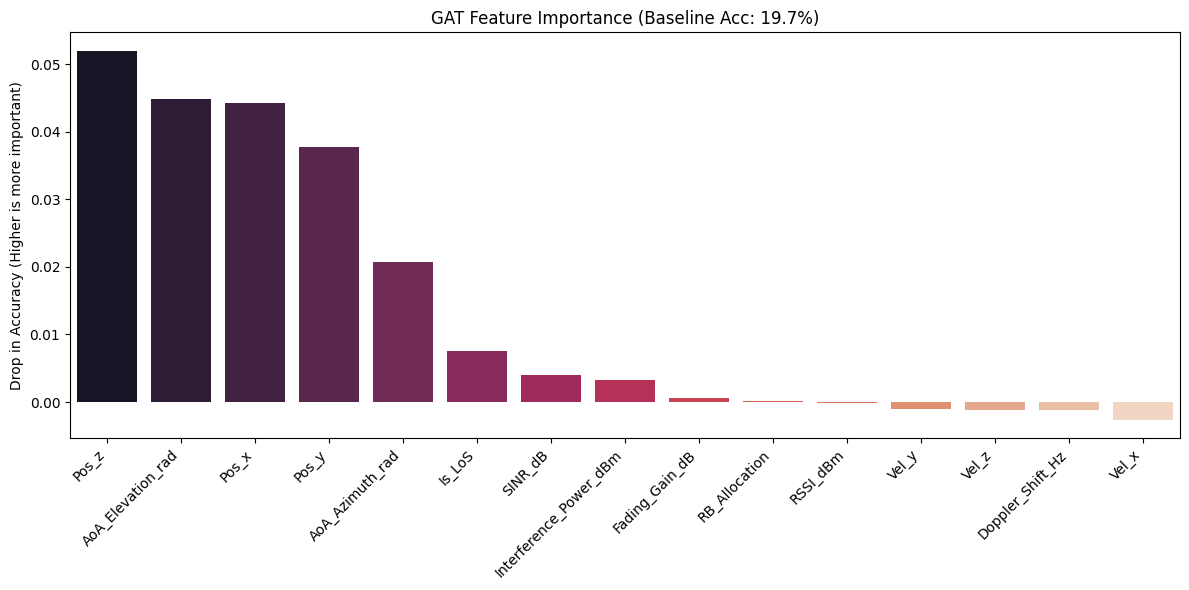

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F # Needed for ELU activation
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv # <--- CHANGED IMPORT
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import copy

# --- CONFIGURATION ---
CSV_FILE = 'uav_dataset_high_speed.csv'
NUM_UAVS = 5
NUM_BEAMS = 64

# NO LABEL LEAKAGE
FEATURES = [
    'Pos_x', 'Pos_y', 'Pos_z',
    'Vel_x', 'Vel_y', 'Vel_z',
    'RSSI_dBm', 'SINR_dB', 'Interference_Power_dBm',
    'Doppler_Shift_Hz', 'AoA_Azimuth_rad', 'AoA_Elevation_rad',
    'RB_Allocation',
    'Is_LoS', 'Fading_Gain_dB'
]

def get_gnn_data(csv_file):
    print("Loading and processing data for GAT...")
    try:
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"Error: {csv_file} not found.")
        return None

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(-999, inplace=True)

    scaler = MinMaxScaler()
    df[FEATURES] = scaler.fit_transform(df[FEATURES])

    graph_list = []
    for t, group in df.groupby('Timestamp'):
        if len(group) != NUM_UAVS: continue

        x = torch.tensor(group[FEATURES].values, dtype=torch.float)

        # Fully connected edges (All-to-All interference potential)
        edge_index = torch.combinations(torch.arange(NUM_UAVS), r=2).T
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

        y = torch.tensor(group['Optimal_Beam_Index'].values, dtype=torch.long)
        graph_list.append(Data(x=x, edge_index=edge_index, y=y))

    return graph_list

# --- UPDATED MODEL: SPATIAL GAT ---
class SpatialGAT(torch.nn.Module):
    def __init__(self):
        super(SpatialGAT, self).__init__()

        # Layer 1: Multi-Head Attention
        # We use 4 heads to look at neighbors in 4 different ways.
        # Output size will be hidden_channels * heads (64 * 4 = 256)
        self.conv1 = GATConv(len(FEATURES), 64, heads=4, dropout=0.2)

        # Layer 2: Aggregation
        # Input size must match Layer 1 output (64 * 4).
        # We usually use 1 head for the final GNN layer before classification.
        self.conv2 = GATConv(64 * 4, 64, heads=1, concat=False, dropout=0.2)

        # Classification Head
        self.head = torch.nn.Linear(64, NUM_BEAMS)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # GAT usually uses ELU activation instead of ReLU
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        x = self.conv2(x, edge_index)
        x = F.elu(x)

        return self.head(x)

def run_gnn_xai():
    data_list = get_gnn_data(CSV_FILE)
    if data_list is None: return

    # Split
    train_size = int(0.8 * len(data_list))
    test_data = data_list[train_size:]
    train_loader = DataLoader(data_list[:train_size], batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    # Initialize GAT Model
    model = SpatialGAT()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005) # Slightly lower LR for GAT
    criterion = torch.nn.CrossEntropyLoss()

    print("\nTraining GAT (30 Epochs)...")
    model.train()
    for epoch in range(30):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    # 1. Baseline Accuracy
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch)
            all_preds.append(out.argmax(dim=1))
            all_labels.append(batch.y)
    baseline_acc = accuracy_score(torch.cat(all_labels), torch.cat(all_preds))
    print(f"\nBaseline GAT Accuracy: {baseline_acc*100:.2f}%")

    # 2. Permutation Importance
    importance = {}
    print("\nRunning Permutation Importance...")

    # Load all test features into one tensor for easy shuffling
    original_features = torch.cat([d.x for d in test_data], dim=0)

    for i, feature_name in enumerate(FEATURES):
        # Shuffle column i
        corrupted_features = original_features.clone()
        idx = torch.randperm(corrupted_features.size(0))
        corrupted_features[:, i] = corrupted_features[idx, i]

        # Re-run inference with corrupted features
        temp_preds = []
        start_idx = 0
        with torch.no_grad():
            for batch in test_loader:
                num_nodes = batch.num_nodes
                batch_x_corrupt = corrupted_features[start_idx : start_idx + num_nodes]

                batch.x = batch_x_corrupt
                out = model(batch)
                temp_preds.append(out.argmax(dim=1))
                start_idx += num_nodes

        corrupted_acc = accuracy_score(torch.cat(all_labels), torch.cat(temp_preds))
        drop = baseline_acc - corrupted_acc
        importance[feature_name] = drop
        print(f"  {feature_name}: Drop = {drop:.4f}")

    # 3. Plot
    sorted_imp = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    names = [x[0] for x in sorted_imp]
    values = [x[1] for x in sorted_imp]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=names, y=values, palette='rocket')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"GAT Feature Importance (Baseline Acc: {baseline_acc*100:.1f}%)")
    plt.ylabel("Drop in Accuracy (Higher is more important)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_gnn_xai()